# Network Analysis of Vagrant Developers
<a href="#TODO's">TODO</a><br>
<a href="#Imports">Imports</a><br>
<a href="#Functions">Functions</a><br>
<a href="#Analysis">Analysis</a><br>
<a href="#Graph-Based-Analysis-using-Logistic-Regression,-Random-Forest-Classifer,-and-XGBoost-classifier"><b>Analysis</b> - Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier</a><br>
<a href="#Cross-Validation"><b>Analysis</b> - Cross Validation</a><br>
<a href="#Rebalancing-data"><b>Analysis</b> - Data Rebalancing</a>

## TODO's

<ul>
<li>Implement a new dataframe to store the results from each section. (refer to last cell)</li>
</ul>

## Imports

In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import json
import csv
import numpy
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, accuracy_score, precision_recall_curve, plot_precision_recall_curve, auc, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, LeaveOneOut, KFold, StratifiedKFold, RepeatedKFold, TimeSeriesSplit
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
import statsmodels.api as sm
from ast import literal_eval
from statistics import mean
from collections import Counter
import sys
import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def plot_prediction(model, x, y):
    '''
    Plots the predictions made using a linear regression model 
    given the set of dependent variable(s) and the independent variable
        model: Linear Regression Model
        x: Dependent Variable(s)
        y: Independent Variable
    returns: Independent Variable Predictions
    '''
    y_pred = model.predict(x)
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='red')
    plt.show()
    
    return y_pred

# source: https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-python-scikit-like-r-does
def regression_results(y_true, y_pred):
    '''
    Analyzes the results from the linear regression model prediction using different metrics, such r^2
    '''
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def Loo(model, x, y):
    '''
    Uses the LeaveOneOut cross-validation method provided by SkLearn
    '''
    loo = LeaveOneOut() 
    highestscore = (0, "")
    y_true, y_pred = list(), list()
    
    # Split the data
    for train_index, test_index in loo.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        predictions = model.predict_proba(x_test)
        yhat = model.predict(x_test) 
        
        # determine PRC_AUC score
        score = model.score(x_test, y_test) # NOTE: Removed the following due to errors: prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if score > highestscore[0]:
            highestscore = (model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}")

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[1])
    print("\nModel Score: {}\n".format(highestscore[0]))
    #acc = accuracy_score(y_true, y_pred)
    #print('Accuracy: %.3f' % acc)
    
    
def Loo_short(model, x, y):
    '''
    Uses the shortened version of the LeaveOneOut cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = LeaveOneOut()
    # to see list of scoring methods, go to: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Rkf(model, x, y, threshold=None):
    '''
    Uses the RepeatedKFold cross-validation method provided by SkLearn
    '''
    kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42) 
    #kf.get_n_splits(x)
    #print(kf)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("Average Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)

    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]
    
def Rkf_short(model, x, y):    
    '''
    Uses the shortened version of the RepeatedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Skf(model, x, y, threshold = None):
    '''
    Uses the StratifiedKFold cross-validation method provided by SkLearn
    '''
    skf = StratifiedKFold(n_splits=10, random_state=None)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
            
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]
    
def Skf_short(model, x, y):
    '''
    Uses the shortened version of the StratifiedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = StratifiedKFold(n_splits=10, random_state=None)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))    

def Tss(model, x, y, threshold=None):
    '''
    Uses the TimeSeriesSplit cross-validation method provided by SkLearn
    '''
    tscv = TimeSeriesSplit(n_splits=5)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    rcall = None
    yhat = None
    
    for train_index, test_index in tscv.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue

        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])

        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]

def Tss_short(model, x, y):
    '''
    Uses the shortened version of the TimeSeriesSplit cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = TimeSeriesSplit(n_splits=10)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores))) 
    
def Compare_Model_Scores(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    
    print("Predictions for model 1: ")
    print(prediction_probs1)
    print("\nPredictions for model 2: ")
    print(prediction_probs2)
    '''
    
    #recall1, recall2, precision1, precision2, thresholds_list = get_precision_recall(test_x1, test_x2, y_test, model1, model2)
    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:, 1]) 
    #retrieve probability of being 1(in second column of probs_y)
    
    pr_auc1 = auc(recall1, precision1)
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    
    pr_auc2 = auc(recall2, precision2)
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2
    
def Compare_Model_Scores_Best_Threshold(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    '''


    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:,1])
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    
    pr_auc1 = auc(recall1[ix1:], precision1[ix1:])
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore2[np.isnan(fscore2)] = 0  
    ix2 = np.argmax(fscore2)
    
    pr_auc2 = auc(recall2[ix2:], precision2[ix2:])
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2

def plot_thresholds(model1, model2, test_x1, test_y1, test_x2, test_y2, prediction_probs1, prediction_probs2, title):
    '''Predict test_y values and probabilities based on fitted logistic for both models''' 

    # recall1, recall2, precision1, precision2, threshold_list = get_precision_recall(test_x1, test_x2, test_y1, model1, model2)
    
    precision1, recall1, thresholds1 = precision_recall_curve(test_y1, prediction_probs1[:, 1]) 
    precision2, recall2, thresholds2 = precision_recall_curve(test_y2, prediction_probs2[:, 1])
    
    # convert to f1 score
    # from: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    fscore2[np.isnan(fscore2)] = 0 
    
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    ix2 = np.argmax(fscore2)
    #print(f"F score 1: {fscore1} with ix: {ix1}")
    #print(f"F score 2: {fscore2} with ix: {ix2}")
    print('Best Threshold=%f, F1-Score=%.3f for model 1' % (thresholds1[ix1], fscore1[ix1]))
    print('Best Threshold=%f, F1-Score=%.3f for model 2' % (thresholds2[ix2], fscore2[ix2]))
    
    
    fig = plt.figure()
    
    plt.title(f"PRC for {title}")
    # use marker = "." to see each threshhold value
    plt.plot(recall1[:-1], precision1[:-1], "b", label=f"Model 1\n-----------\n • PRC-AUC score: {auc(recall1[ix1:], precision1[ix1:]):.2f}\n • Best Threshold: {round(thresholds1[ix1], 2):.2f}\n • Best F1-Score: {round(fscore1[ix1], 2):.2f}\n")
    plt.plot(recall2[:-1], precision2[:-1], "r--", label=f"Model 2\n-----------\n • PRC-AUC score: {auc(recall2[ix2:], precision2[ix2:]):.2f}\n • Best Threshold: {round(thresholds2[ix2], 2):.2f}\n • Best F1-Score: {round(fscore2[ix2], 2):.2f}")
    plt.scatter([recall1[ix1], recall2[ix2]], [precision1[ix1], precision2[ix2]], marker='o', color='black', label='Best threshold')
    #plt.annotate('Model 1 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds1[ix1], fscore1[ix1]), (0.38, 0.35), fontsize=8)
    #plt.annotate('Model 2 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds2[ix2], fscore2[ix2]), (0.38, 0.3), fontsize=8)
    
    x1 = np.array(recall1[ix1:], dtype=float)
    x2 = np.array(recall2[ix2:], dtype=float)
    y1 = np.array(precision1[ix1:], dtype=float)
    y2 = np.array(precision2[ix2:], dtype=float)
    y1_opp = np.array(precision1[ix2:], dtype=float)
    
    #plt.fill_between(x1, y1, color='b', alpha=0.5)
    # where=y1_opp<=y2
    #plt.fill_between(x2, y2, color='r', alpha=0.3)
    
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.ylim([0,1])
    plt.xlim([0,1])
    
    plt.grid()
    plt.show()
    
    return thresholds1[ix1], thresholds2[ix2], fig
    
def simple_threshold_plot(classifier, x_test, y_test):
    predictions = classifier.predict(x_test)
    prc_val = average_precision_score(y_test, predictions)
    disp = plot_precision_recall_curve(classifier, x_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(prc_val))
    
def get_precision_recall(test_x1, test_x2, test_y, model1, model2):
    '''
    Get the the preicison and recall values for every data point with each type of threshold
    '''
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, 1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
        
    return recall1, recall2, precision1, precision2, threshold_list

def get_precision_recall_best_thresh(test_x1, test_x2, test_y, model1, model2, best_thresh1=None, best_thresh2=None):
    '''
    Get the the preicison and recall values for every data point with the best threshold
    '''
    limit1, limit2 = 1, 1
    if best_thresh1 != None:
        limit1 = best_thresh1
    if best_thresh2 != None:
        limit2 = best_thresh2
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, limit1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        
    threshold_list = np.arange(0.001, limit2, 0.001)
    for threshold in threshold_list:
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
    return recall1, recall2, precision1, precision2, threshold_list

## Analysis

### Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier

In [3]:
# Create a dataframe of all of the unique commits (i.e. links) between developers and the corresponding folders
graph_df = pd.read_csv("../../Neo4j_output/JiT_Reliability_Output/Lucene.csv")

new_columns = {}

# Generate binary classification for our dataframe based on if a developer 
# introduced a bug or not with the corresponding commit
for index in graph_df.index:
    if graph_df.loc[index, "Bug"] != "INTRODUCED_NEW_BUG":
        graph_df.loc[index, "Bug"] = 0
    else:
        graph_df.loc[index, "Bug"] = 1
        
    # separate each node2vec embedding into it's own unique label
    embeddings = literal_eval(graph_df.loc[index, 'n2vEmbedding'])
    for i, embedding in enumerate(embeddings):
        if f"emb_{i}" not in new_columns:
            new_columns[f"emb_{i}"] = []
            new_columns[f"emb_{i}"].append(embedding)
        else:
            new_columns[f"emb_{i}"].append(embedding)

# delete the n2vEmbedding label, as the list has now been separated into their own unique labels 
del graph_df['n2vEmbedding']
temp_df = pd.DataFrame.from_dict(new_columns)
graph_df = graph_df.join(temp_df)
            
graph_df['Bug'] = graph_df.Bug.astype('int')
    
x = graph_df["Name"]
y = graph_df["Bug"]

In [4]:
graph_df

,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,emb_0,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,Geoffrey Lawson,lucene/analysis/common/src/test/org/apache/luc...,0,0.150053,0.000000,0.485549,0.486726,1.0,12,0.930835,...,0.92789,-0.284535,0.665341,0.229854,0.924209,-0.565990,-0.394312,-0.218945,0.130041,-0.541419
1,Mike McCandless,lucene/replicator/src/test/org/apache/lucene/r...,0,6.629098,1203.705481,0.825553,0.887414,168878.0,12,0.045165,...,0.31104,-0.203509,0.074990,0.047616,-0.056431,0.003525,0.262560,-0.222399,0.052627,0.213322
2,Mike McCandless,lucene/sandbox/src/test/org/apache/lucene/util...,0,6.629098,1203.705481,0.825553,0.887414,168878.0,12,0.045165,...,0.31104,-0.203509,0.074990,0.047616,-0.056431,0.003525,0.262560,-0.222399,0.052627,0.213322
3,Mike McCandless,lucene/sandbox/src/test/org/apache/lucene/util...,0,6.629098,1203.705481,0.825553,0.887414,168878.0,12,0.045165,...,0.31104,-0.203509,0.074990,0.047616,-0.056431,0.003525,0.262560,-0.222399,0.052627,0.213322
4,Mike McCandless,lucene/sandbox/src/test/org/apache/lucene/sear...,0,6.629098,1203.705481,0.825553,0.887414,168878.0,12,0.045165,...,0.31104,-0.203509,0.074990,0.047616,-0.056431,0.003525,0.262560,-0.222399,0.052627,0.213322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349173,Sam Ruby,docs/features.html,1,0.242447,0.199975,0.535885,0.564897,152.0,339,-0.027781,...,0.20993,0.520862,0.537258,0.313103,0.445739,-0.689745,0.241217,-0.155622,0.249996,-0.578251
349174,Sam Ruby,build.sh,1,0.242447,0.199975,0.535885,0.564897,152.0,339,-0.027781,...,0.20993,0.520862,0.537258,0.313103,0.445739,-0.689745,0.241217,-0.155622,0.249996,-0.578251
349175,Sam Ruby,Attic/api/overview.html,1,0.242447,0.199975,0.535885,0.564897,152.0,339,-0.027781,...,0.20993,0.520862,0.537258,0.313103,0.445739,-0.689745,0.241217,-0.155622,0.249996,-0.578251
349176,Sam Ruby,xdocs/resources.xml,1,0.242447,0.199975,0.535885,0.564897,152.0,339,-0.027781,...,0.20993,0.520862,0.537258,0.313103,0.445739,-0.689745,0.241217,-0.155622,0.249996,-0.578251


Print out the class counts for our binary classification. In this case, our results are 40,143 <b>False (0)</b> counts, and 1,947 <b>True (1)</b> counts.

In [5]:
print(graph_df['Bug'].value_counts())
# 2D Array containing all results
results_data = [[None for j in range(9)] for i in range(72)]

0    277547
1     71631
Name: Bug, dtype: int64


Creating models...

In [6]:
lr_model1 = LogisticRegression(solver='liblinear', random_state=0)
lr_model2 = LogisticRegression(solver='liblinear', random_state=0)
rf_model1 = RandomForestClassifier(n_estimators=120)
rf_model2 = RandomForestClassifier(n_estimators=120)
xgb_model1 = XGBClassifier(verbosity = 0)
xgb_model2 = XGBClassifier(verbosity = 0)

In [7]:
'''
train_test_split params
-----------------------
graph_df: Graph dataset
test_size: float value between 0.0 and 1.0 representing the precentage of data to be put into the test dataset
random_state = used to create reproducible, or deterministic results.
'''
train, test = train_test_split(graph_df, test_size=0.3, random_state = 5)
train = train.reset_index()
test = test.reset_index()

# Labels used for model 1
labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']

# Labels used for model 2
labels2 = set(list(graph_df.columns))
labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

x1_train = train[labels1]
x2_train = train[labels2]
y_train = train["Bug"]
x1_test = test[labels1]
x2_test = test[labels2]
y_test = test["Bug"]

In [8]:
print(train['Bug'].value_counts())
train

0    194369
1     50055
Name: Bug, dtype: int64


,index,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,193086,Alessandro Benedetti,lucene/analysis/common/src/java/org/apache/luc...,0,3.210418,786.813249,0.837905,0.895280,16235.0,78,...,0.208156,0.329620,-0.112938,-0.057695,0.220680,0.006301,-0.029071,-0.207716,0.029565,0.017862
1,213741,Simon Willnauer,modules/analysis/common/src/java/org/apache/lu...,1,3.734914,1454.534373,0.825553,0.886431,126947.0,12,...,0.222190,-0.015470,0.266682,0.131514,-0.008256,-0.116422,0.537466,-0.245966,0.223811,0.103143
2,40333,Dawid Weiss,solr/{src => }/scripts/snapshooter,0,10.873549,8806.265048,0.941176,0.960177,173842.0,12,...,0.129079,0.120637,0.017950,0.084147,0.242222,-0.035878,0.155243,-0.072398,0.179503,0.125754
3,293869,Steven Rowe,dev-tools/maven/solr/core/src/java/pom.xml.tem...,0,4.546566,923.371296,0.819512,0.882006,115332.0,12,...,0.107167,-0.001284,-0.185339,-0.455532,-0.037595,-0.143318,0.442934,0.045210,0.142910,-0.198143
4,85411,Robert Muir,lucene/core/src/java/org/apache/lucene/codecs/...,0,8.797701,5442.622793,0.896000,0.933628,457360.0,12,...,0.166504,0.110983,-0.106767,-0.179607,-0.075737,0.055637,0.389563,-0.166684,0.189453,-0.128410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244419,232422,Erick Erickson,solr/CHANGES.txt,0,5.292088,1899.983822,0.846348,0.901180,124375.0,78,...,0.301843,-0.187152,0.058248,-0.158017,-0.160520,0.000454,0.288653,0.044201,-0.022791,-0.056959
244420,124605,Uwe Schindler,contrib/queryparser/src/java/org/apache/lucene...,0,6.570087,3102.382730,0.863753,0.912979,225832.0,12,...,0.255830,0.367472,0.166609,0.027299,0.356481,-0.308061,0.188302,0.041795,0.095797,0.044560
244421,20463,Adrien Grand,solr/contrib/analytics/src/java/org/apache/sol...,0,4.626924,2347.322709,0.840000,0.896755,174638.0,12,...,0.007187,0.061467,0.077150,-0.008879,0.239871,0.046126,0.102227,-0.205986,0.052734,0.122526
244422,18638,Adrien Grand,lucene/misc/src/test/org/apache/lucene/search/...,0,4.626924,2347.322709,0.840000,0.896755,174638.0,12,...,0.007187,0.061467,0.077150,-0.008879,0.239871,0.046126,0.102227,-0.205986,0.052734,0.122526


Print out the class counts for our binary classification in the training dataset. In this case, our results are 12,060 <b>False (0)</b> counts, and 567 <b>True (1)</b> counts.

In [9]:
print(test['Bug'].value_counts())
test

0    83178
1    21576
Name: Bug, dtype: int64


,index,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,134751,Uwe Schindler,solr/core/src/test/org/apache/solr/cloud/Custo...,0,6.570087,3102.382730,0.863753,0.912979,225832.0,12,...,0.255830,0.367472,0.166609,0.027299,0.356481,-0.308061,0.188302,0.041795,0.095797,0.044560
1,192855,Alessandro Benedetti,solr/solr-ref-guide/src/suggester.adoc,0,3.210418,786.813249,0.837905,0.895280,16235.0,78,...,0.208156,0.329620,-0.112938,-0.057695,0.220680,0.006301,-0.029071,-0.207716,0.029565,0.017862
2,229109,Shalin Shekhar Mangar,solr/core/src/test-files/solr/solr-solrreporte...,0,5.831383,2347.979934,0.870466,0.917404,195316.0,78,...,0.182995,0.022565,-0.194516,-0.012167,0.386468,-0.020608,0.047107,-0.241878,0.060015,0.175835
3,324729,Koji Sekiguchi,solr/src/java/org/apache/solr/analysis/LimitTo...,0,1.452246,456.575445,0.794326,0.862832,15720.0,12,...,0.193838,-0.131832,-0.074864,-0.303660,-0.055490,0.229955,0.141866,-0.044534,-0.274380,-0.030086
4,177929,Joel Bernstein,solr/core/src/java/org/apache/solr/handler/sql...,0,1.430393,518.176519,0.768879,0.843166,43114.0,78,...,0.096788,-0.194134,0.140157,-0.036192,0.176071,-0.090670,0.169624,0.008241,0.214103,-0.006923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104749,244890,Erik Hatcher,client/ruby/flare/public/stylesheets/flare.css,0,2.313244,2831.127054,0.809639,0.874631,30625.0,78,...,0.488612,0.187670,-0.133451,-0.216428,0.149079,-0.153032,0.150495,-0.036999,-0.207340,-0.150963
104750,249176,Mikhail Khludnev,solr/core/src/java/org/apache/solr/core/backup...,0,1.673649,382.544388,0.768879,0.843166,25863.0,78,...,0.317993,-0.236750,0.018697,0.066542,-0.065198,-0.293813,0.359924,-0.109696,0.078034,0.584643
104751,106172,Robert Muir,lucene/test-framework/src/java/org/apache/luce...,0,8.797701,5442.622793,0.896000,0.933628,457360.0,12,...,0.166504,0.110983,-0.106767,-0.179607,-0.075737,0.055637,0.389563,-0.166684,0.189453,-0.128410
104752,172005,Andrzej Bialecki,solr/core/src/java/org/apache/solr/metrics/rep...,0,3.064391,883.241713,0.794326,0.862832,72851.0,78,...,0.473991,0.116267,-0.023252,0.141946,0.017865,-0.164373,0.345025,0.052589,0.256739,0.030777


In [10]:
lr_model1.fit(x1_train, y_train)
lr_model2.fit(x2_train, y_train)
rf_model1.fit(x1_train, y_train)
rf_model2.fit(x2_train, y_train)
xgb_model1.fit(x1_train, y_train)
xgb_model2.fit(x2_train, y_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y_test)}")
results_data[0][0] = "Original_Logistic_Regression"
results_data[0][1] = lr_model1.score(x1_test, y_test)
results_data[0][2] = lr_model2.score(x2_test, y_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y_test)}")
results_data[1][0] = "Original_Random_Forrest"
results_data[1][1] = rf_model1.score(x1_test, y_test)
results_data[1][2] = rf_model2.score(x2_test, y_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y_test)}")
results_data[2][0] = "Original_XGB_Classifier"
results_data[2][1] = xgb_model1.score(x1_test, y_test)
results_data[2][2] = xgb_model2.score(x2_test, y_test)

Logistic regression training score for model 1: 0.7862706913339824
Logistic regression training score for model 2: 0.8060790041430399
Random Forrest Classification training score for model 1: 0.8064799434866449
Random Forrest Classification training score for model 2: 0.8064799434866449
XGB Classifier training score for model 1: 0.8064799434866449
XGB Classifier training score for model 2: 0.8064799434866449


Compare model scores for Logistic Regression

In [11]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[0][3] = acc1
results_data[0][4] = acc2
results_data[0][5] = prc_val1
results_data[0][6] = prc_val2
results_data[0][7] = pr_auc1
results_data[0][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[1][3] = acc1
results_data[1][4] = acc2
results_data[1][5] = prc_val1
results_data[1][6] = prc_val2
results_data[1][7] = pr_auc1
results_data[1][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[2][3] = acc1
results_data[2][4] = acc2
results_data[2][5] = prc_val1
results_data[2][6] = prc_val2
results_data[2][7] = pr_auc1
results_data[2][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.4873176390001196
Average Precision-Recall Score: 0.19709444865881853
PRC-AUC for model 1: 0.1901272105007165
Accuracy: 0.786
Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.99      0.88     83178
           1       0.06      0.00      0.00     21576

    accuracy                           0.79    104754
   macro avg       0.42      0.50      0.44    104754
weighted avg       0.64      0.79      0.70    104754


Scores for model 2
------------------
Roc_Auc Score: 0.7736782655974184
Average Precision-Recall Score: 0.43299709943215037
PRC-AUC for model 2: 0.445764833920279
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     83178
           1       0.60      0.18      0.27     21576

    accuracy     

###### Compare Precision-Recall thresholds between models

TODO: Get it to work with randomforrest and XGBoost

Best Threshold=0.124524, F1-Score=0.361 for model 1
Best Threshold=0.231844, F1-Score=0.484 for model 2


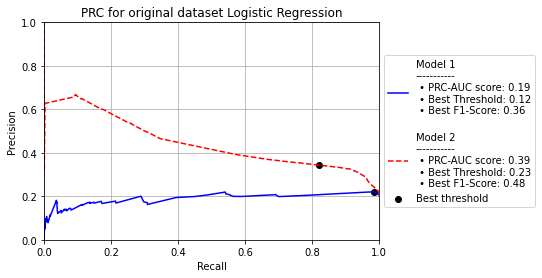

In [12]:
lr_best_threshold1, lr_best_threshold2, lr_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "original dataset Logistic Regression")

Best Threshold=0.243248, F1-Score=0.487 for model 1
Best Threshold=0.244724, F1-Score=0.487 for model 2


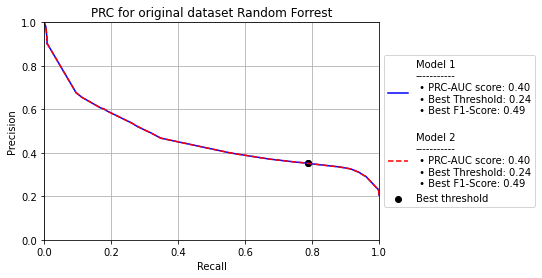

In [13]:
rf_best_threshold1, rf_best_threshold2, rf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "original dataset Random Forrest")

Best Threshold=0.243549, F1-Score=0.487 for model 1
Best Threshold=0.243075, F1-Score=0.487 for model 2


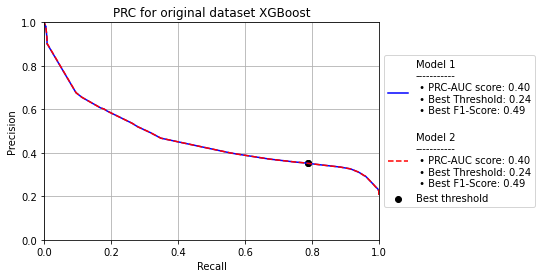

In [14]:
xgb_best_threshold1, xgb_best_threshold2, xgb_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "original dataset XGBoost")

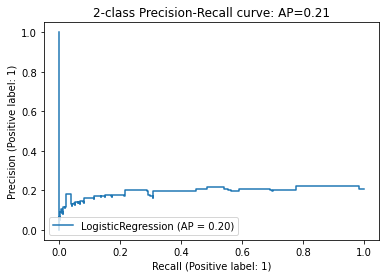

In [15]:
simple_threshold_plot(lr_model1, x1_test, y_test)

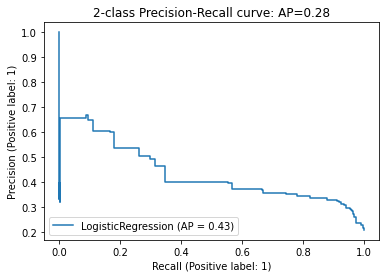

In [16]:
simple_threshold_plot(lr_model2, x2_test, y_test)

Using the best thresholds...

In [17]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)

results_data[3][0] = "Original_Logistic_Regression_Best_Threshold"
results_data[3][1] = lr_model1.score(x1_test, y_test)
results_data[3][2] = lr_model2.score(x2_test, y_test)
results_data[3][3] = acc1
results_data[3][4] = acc2
results_data[3][5] = prc_val1
results_data[3][6] = prc_val2
results_data[3][7] = pr_auc1
results_data[3][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[4][0] = "Original_Random_Forrest_Best_Threshold"
results_data[4][1] = rf_model1.score(x1_test, y_test)
results_data[4][2] = rf_model2.score(x2_test, y_test)
results_data[4][3] = acc1
results_data[4][4] = acc2
results_data[4][5] = prc_val1
results_data[4][6] = prc_val2
results_data[4][7] = pr_auc1
results_data[4][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[5][0] = "Original_XGBoost_Classifier_Best_Threshold"
results_data[5][1] = xgb_model1.score(x1_test, y_test)
results_data[5][2] = xgb_model2.score(x2_test, y_test)
results_data[5][3] = acc1
results_data[5][4] = acc2
results_data[5][5] = prc_val1
results_data[5][6] = prc_val2
results_data[5][7] = pr_auc1
results_data[5][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.4873176390001196
Average Precision-Recall Score: 0.19709444865881853
PRC-AUC for model 1: 0.18685254403604565
Accuracy: 0.282
Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.10      0.18     83178
           1       0.22      0.98      0.36     21576

    accuracy                           0.28    104754
   macro avg       0.59      0.54      0.27    104754
weighted avg       0.81      0.28      0.22    104754


Scores for model 2
------------------
Roc_Auc Score: 0.7736782655974184
Average Precision-Recall Score: 0.43299709943215037
PRC-AUC for model 2: 0.39090574400275124
Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.59      0.72     83178
           1       0.34      0.82      0.48     21576

    accuracy                           0.64    104754
   macro avg       0.64      0.71      0.60    104754
weigh

### Cross Validation

In [18]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df['Bug']

In [19]:
print("Cross validation results for model 1")
print("------------------------------------")

cv_results = cross_validate(lr_model1, x1, y, cv=3)
sorted(cv_results.keys())
print(cv_results['test_score'])

print("\nCross validation results for model 2")
print("------------------------------------")

cv_results = cross_validate(lr_model2, x2, y, cv=3)
sorted(cv_results.keys())
print(cv_results['test_score'])

Cross validation results for model 1
------------------------------------
[0.79395668 0.78557989 0.77709808]

Cross validation results for model 2
------------------------------------
[0.37243649 0.66958494 0.3538903 ]


#### Model 1 Cross Validation

#### Leave One Out

In [20]:
# NOTE: Running extremely slow, working on this issue
#Loo(lr_model1, x1, y)

#### Repeated KFold

In [21]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, x1, y)
results_data[6][0] = "Original_Logistic_Regression_rkf"
results_data[6][1] = model_score
results_data[6][3] = acc
results_data[6][5] = prc_val
results_data[6][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, x1, y, lr_best_threshold1)
results_data[7][0] = "Original_Logistic_Regression_rkf_Best_Threshold"
results_data[7][1] = model_score
results_data[7][3] = acc
results_data[7][5] = prc_val
results_data[7][7] = pr_auc

Rkf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, x1, y)
results_data[8][0] = "Original_Random_Forrest_rkf"
results_data[8][1] = model_score
results_data[8][3] = acc
results_data[8][5] = prc_val
results_data[8][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, x1, y)
results_data[9][0] = "Original_XGB_Classifier_rkf"
results_data[9][1] = model_score
results_data[9][3] = acc
results_data[9][5] = prc_val
results_data[9][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 349175 349176 349177] | TEST: [    21     28     35 ... 349141 349149 349161]

Model Score: 0.7820545865910588
Average Precision-Recall Score: 0.2099716516893501
PRC-AUC Score: 0.18777080436152382
Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.99      0.88     27573
           1       0.06      0.00      0.00      7344

    accuracy                           0.78     34917
   macro avg       0.42      0.50      0.44     34917
weighted avg       0.63      0.78      0.69     34917

Accuracy: 0.782
---------------------
With best threshold
TRAIN: [     0      1      2 ... 349175 349176 349177] | TEST: [    21     28     35 ... 349141 349149 349161]

Model Score: 0.7820545865910588
Average Precision-Recall Score: 0.2099716516893501
PRC-AUC Score: 0.5137635548622512
Classificat

#### Stratified KFold

In [22]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, x1, y)
results_data[10][0] = "Original_Logistic_Regression_skf"
results_data[10][1] = model_score
results_data[10][3] = acc
results_data[10][5] = prc_val
results_data[10][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, x1, y, lr_best_threshold1)
results_data[11][0] = "Original_Logistic_Regression_skf_Best_Threshold"
results_data[11][1] = model_score
results_data[11][3] = acc
results_data[11][5] = prc_val
results_data[11][7] = pr_auc

Skf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, x1, y)
results_data[12][0] = "Original_Random_Forrest_skf"
results_data[12][1] = model_score
results_data[12][3] = acc
results_data[12][5] = prc_val
results_data[12][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, x1, y)
results_data[13][0] = "Original_XGB_Classifier_skf"
results_data[13][1] = model_score
results_data[13][3] = acc
results_data[13][5] = prc_val
results_data[13][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 349175 349176 349177] | TEST: [199411 199412 199413 ... 287787 287788 287789]

Model Score: 0.7944326708287989

Average Precision-Recall Score: 0.20522267461630403
PRC-AUC Score: 0.37797920366144194
Classification Report:

              precision    recall  f1-score   support

           0       0.79      1.00      0.89     27755
           1       0.27      0.00      0.00      7163

    accuracy                           0.79     34918
   macro avg       0.53      0.50      0.44     34918
weighted avg       0.69      0.79      0.70     34918

Accuracy: 0.794
---------------------
With best threshold
TRAIN: [     0      1      2 ... 349175 349176 349177] | TEST: [199411 199412 199413 ... 287787 287788 287789]

Model Score: 0.7944326708287989

Average Precision-Recall Score: 0.20522267461630403
PRC-AUC Score: 0.6025688756515264
Classif

#### Time Series Split

In [23]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, x1, y)
results_data[14][0] = "Original_Logistic_Regression_tss"
results_data[14][1] = model_score
results_data[14][3] = acc
results_data[14][5] = prc_val
results_data[14][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, x1, y, lr_best_threshold1)
results_data[15][0] = "Original_Logistic_Regression_tss_Best_Threshold"
results_data[15][1] = model_score
results_data[15][3] = acc
results_data[15][5] = prc_val
results_data[15][7] = pr_auc

Skf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Tss(rf_model1, x1, y)
results_data[16][0] = "Original_Random_Forrest_tss"
results_data[16][1] = model_score
results_data[16][3] = acc
results_data[16][5] = prc_val
results_data[16][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, x1, y)
results_data[17][0] = "Original_XGB_Classifier_tss"
results_data[17][1] = model_score
results_data[17][3] = acc
results_data[17][5] = prc_val
results_data[17][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 290979 290980 290981] | TEST: [290982 290983 290984 ... 349175 349176 349177]

Model Score: 0.62605677366142

Average Precision-Recall Score: 0.3461584633992685
PRC-AUC Score: 0.2792683150404572
Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.95      0.77     37855
           1       0.18      0.02      0.04     20341

    accuracy                           0.63     58196
   macro avg       0.41      0.49      0.40     58196
weighted avg       0.48      0.63      0.51     58196

Accuracy: 0.626
---------------------
With best threshold
TRAIN: [     0      1      2 ... 290979 290980 290981] | TEST: [290982 290983 290984 ... 349175 349176 349177]

Model Score: 0.62605677366142

Average Precision-Recall Score: 0.3461584633992685
PRC-AUC Score: 0.6747628703003643
Classification

#### Model 2 Cross Validation

#### Leave One Out

In [24]:
# NOTE: Running extremely slow, working on this issue
#Loo(lr_model2, x2, y)

#### Repeated KFold

In [25]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, x2, y)
results_data[6][2] = model_score
results_data[6][4] = acc
results_data[6][6] = prc_val
results_data[6][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, x2, y, lr_best_threshold2)
results_data[7][2] = model_score
results_data[7][4] = acc
results_data[7][6] = prc_val
results_data[7][8] = pr_auc

Rkf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, x2, y)
results_data[8][2] = model_score
results_data[8][4] = acc
results_data[8][6] = prc_val
results_data[8][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, x2, y)
results_data[9][2] = model_score
results_data[9][4] = acc
results_data[9][6] = prc_val
results_data[9][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 349175 349176 349177] | TEST: [     6     11     12 ... 349151 349165 349170]

Model Score: 0.8049143708116158
Average Precision-Recall Score: 0.28487992242246235
PRC-AUC Score: 0.3948596377343391
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     27598
           1       0.61      0.19      0.29      7320

    accuracy                           0.80     34918
   macro avg       0.72      0.58      0.59     34918
weighted avg       0.78      0.80      0.76     34918

Accuracy: 0.805
---------------------
With best threshold
TRAIN: [     0      1      2 ... 349175 349176 349177] | TEST: [     6     11     12 ... 349151 349165 349170]

Model Score: 0.8049143708116158
Average Precision-Recall Score: 0.28487992242246235
PRC-AUC Score: 0.5890877032282275
Classifica

#### Stratified KFold

In [26]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, x2, y)
results_data[10][2] = model_score
results_data[10][4] = acc
results_data[10][6] = prc_val
results_data[10][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, x2, y, lr_best_threshold2)
results_data[11][2] = model_score
results_data[11][4] = acc
results_data[11][6] = prc_val
results_data[11][8] = pr_auc

Skf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, x2, y)
results_data[12][2] = model_score
results_data[12][4] = acc
results_data[12][6] = prc_val
results_data[12][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model2, x2, y)
results_data[13][2] = model_score
results_data[13][4] = acc
results_data[13][6] = prc_val
results_data[13][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 349175 349176 349177] | TEST: [231646 231647 231648 ... 311076 311077 311078]

Model Score: 0.1926799931267541

Average Precision-Recall Score: 0.20516638982759608
PRC-AUC Score: 0.11113576579652555
Classification Report:

              precision    recall  f1-score   support

           0       0.48      0.24      0.32     27754
           1       0.00      0.00      0.00      7164

    accuracy                           0.19     34918
   macro avg       0.24      0.12      0.16     34918
weighted avg       0.38      0.19      0.26     34918

Accuracy: 0.193
---------------------
With best threshold
TRAIN: [     0      1      2 ... 349175 349176 349177] | TEST: [231646 231647 231648 ... 311076 311077 311078]

Model Score: 0.1926799931267541

Average Precision-Recall Score: 0.20516638982759608
PRC-AUC Score: 0.10258319491379804
Classi

#### Time Series Split

In [27]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, x2, y)
results_data[14][2] = model_score
results_data[14][4] = acc
results_data[14][6] = prc_val
results_data[14][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, x2, y, lr_best_threshold2)
results_data[15][2] = model_score
results_data[15][4] = acc
results_data[15][6] = prc_val
results_data[15][8] = pr_auc

Skf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Tss(rf_model2, x2, y)
results_data[16][2] = model_score
results_data[16][4] = acc
results_data[16][6] = prc_val
results_data[16][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, x2, y)
results_data[17][2] = model_score
results_data[17][4] = acc
results_data[17][6] = prc_val
results_data[17][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 290979 290980 290981] | TEST: [290982 290983 290984 ... 349175 349176 349177]

Model Score: 0.4756512475084198

Average Precision-Recall Score: 0.32412203286826863
PRC-AUC Score: 0.2876748443686486
Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.63      0.61     37855
           1       0.22      0.19      0.20     20341

    accuracy                           0.48     58196
   macro avg       0.40      0.41      0.41     58196
weighted avg       0.46      0.48      0.47     58196

Accuracy: 0.476
---------------------
With best threshold
TRAIN: [     0      1      2 ... 290979 290980 290981] | TEST: [290982 290983 290984 ... 349175 349176 349177]

Model Score: 0.4756512475084198

Average Precision-Recall Score: 0.32412203286826863
PRC-AUC Score: 0.346167221460174
Classific

Best Threshold=0.124305, F1-Score=0.366 for model 1
Best Threshold=0.253199, F1-Score=0.496 for model 2


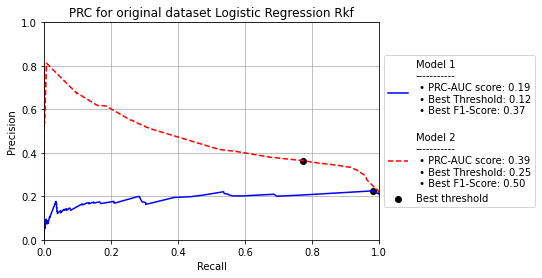

Best Threshold=0.254095, F1-Score=0.498 for model 1
Best Threshold=0.252665, F1-Score=0.498 for model 2


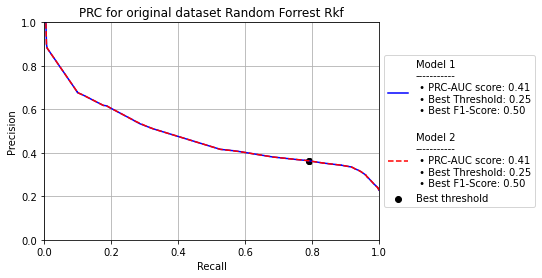

Best Threshold=0.252957, F1-Score=0.498 for model 1
Best Threshold=0.252289, F1-Score=0.498 for model 2


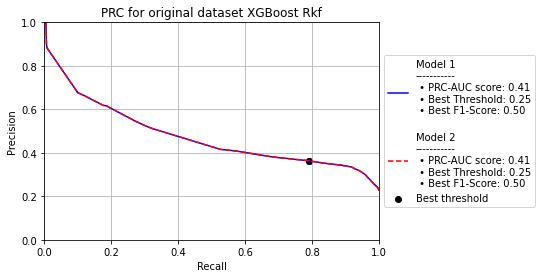

Best Threshold=0.385738, F1-Score=0.670 for model 1
Best Threshold=0.004657, F1-Score=0.350 for model 2


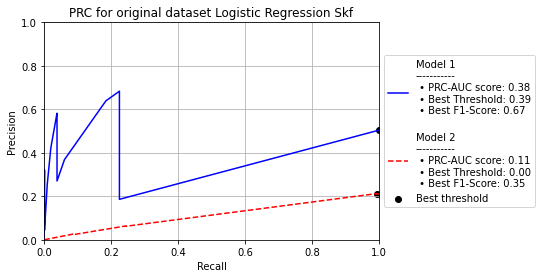

Best Threshold=0.000000, F1-Score=0.340 for model 1
Best Threshold=0.000000, F1-Score=0.340 for model 2


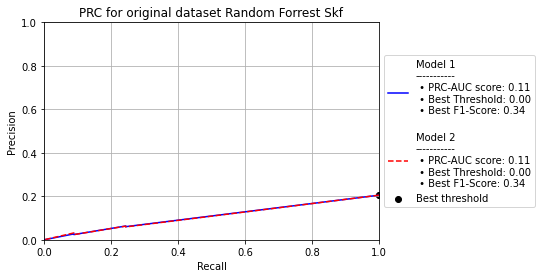

Best Threshold=0.000529, F1-Score=0.341 for model 1
Best Threshold=0.000024, F1-Score=0.340 for model 2


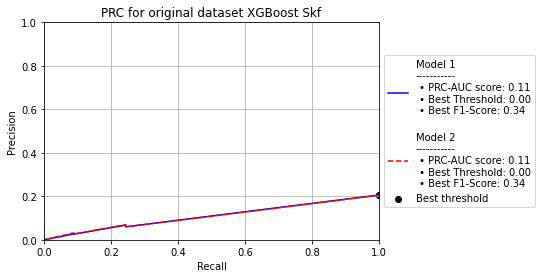

Best Threshold=0.375500, F1-Score=0.518 for model 1
Best Threshold=0.000000, F1-Score=0.518 for model 2


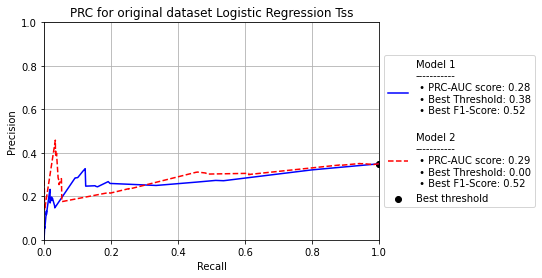

Best Threshold=0.000000, F1-Score=0.518 for model 1
Best Threshold=0.000000, F1-Score=0.518 for model 2


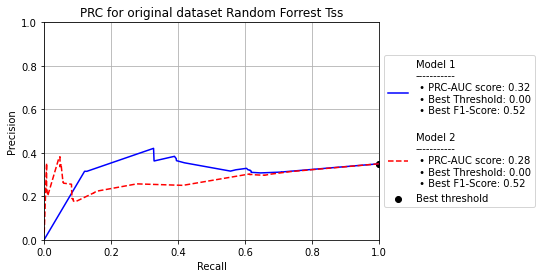

Best Threshold=0.000316, F1-Score=0.524 for model 1
Best Threshold=0.000042, F1-Score=0.518 for model 2


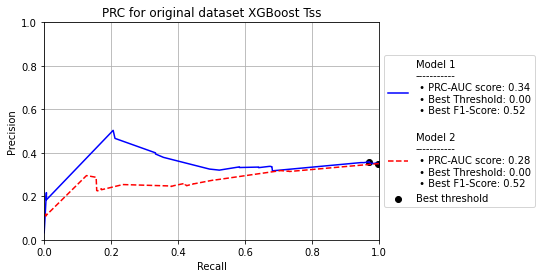

In [28]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "original dataset Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "original dataset Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "original dataset XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "original dataset Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "original dataset Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "original dataset XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "original dataset Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "original dataset Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "original dataset XGBoost Tss")

### Rebalancing data

#### Undersampling

In [29]:
bug_df = graph_df.loc[graph_df['Bug'] == 1].sample(n=1900, random_state=42)
non_bug_df = graph_df.loc[graph_df['Bug'] == 0].sample(n=1900, random_state=42)
normalized_under_df = pd.concat([bug_df, non_bug_df])
normalized_under_df = normalized_under_df.reset_index()
print(normalized_under_df['Bug'].value_counts())

usx1 = normalized_under_df[labels1]
usx2 = normalized_under_df[labels2]
usy = normalized_under_df["Bug"]
usy = usy.sample(frac=1).reset_index(drop=True) # shuffle dataset

train, test = train_test_split(normalized_under_df, test_size=0.3, random_state = 5)

labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']
labels2 = set(list(normalized_under_df.columns))
labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

x1_train = train[labels1]
x2_train = train[labels2]
y_train = train["Bug"]
x1_test = test[labels1]
x2_test = test[labels2]
y_test = test["Bug"]

0    1900
1    1900
Name: Bug, dtype: int64


In [30]:
lr_model1.fit(x1_train, y_train)
lr_model2.fit(x2_train, y_train)
rf_model1.fit(x1_train, y_train)
rf_model2.fit(x2_train, y_train)
xgb_model1.fit(x1_train, y_train)
xgb_model2.fit(x2_train, y_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y_test)}")
results_data[18][0] = "Undersampled_Logistic_Regression"
results_data[18][1] = lr_model1.score(x1_test, y_test)
results_data[18][2] = lr_model2.score(x2_test, y_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y_test)}")
results_data[19][0] = "Undersampled_Random_Forrest"
results_data[19][1] = rf_model1.score(x1_test, y_test)
results_data[19][2] = rf_model2.score(x2_test, y_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y_test)}")
results_data[20][0] = "Undersampled_XGB_Classifier"
results_data[20][1] = xgb_model1.score(x1_test, y_test)
results_data[20][2] = xgb_model2.score(x2_test, y_test)

Logistic regression training score for model 1: 0.5807017543859649
Logistic regression training score for model 2: 0.6894736842105263
Random Forrest Classification training score for model 1: 0.7
Random Forrest Classification training score for model 2: 0.7008771929824561
XGB Classifier training score for model 1: 0.7017543859649122
XGB Classifier training score for model 2: 0.7017543859649122


In [31]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[18][3] = acc1
results_data[18][4] = acc2
results_data[18][5] = prc_val1
results_data[18][6] = prc_val2
results_data[18][7] = pr_auc1
results_data[18][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[19][3] = acc1
results_data[19][4] = acc2
results_data[19][5] = prc_val1
results_data[19][6] = prc_val2
results_data[19][7] = pr_auc1
results_data[19][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[20][3] = acc1
results_data[20][4] = acc2
results_data[20][5] = prc_val1
results_data[20][6] = prc_val2
results_data[20][7] = pr_auc1
results_data[20][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.5965984153037438
Average Precision-Recall Score: 0.5538997165475096
PRC-AUC for model 1: 0.5500053365919174
Accuracy: 0.581
Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.30      0.42       583
           1       0.54      0.87      0.67       557

    accuracy                           0.58      1140
   macro avg       0.63      0.59      0.55      1140
weighted avg       0.63      0.58      0.54      1140


Scores for model 2
------------------
Roc_Auc Score: 0.7526090825945166
Average Precision-Recall Score: 0.6892414285977444
PRC-AUC for model 2: 0.6883879711579656
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.60      0.66       583
           1       0.65      0.79      0.71       557

    accuracy      

###### Compare Precision-Recall thresholds between models for undersampling

Best Threshold=0.485476, F1-Score=0.684 for model 1
Best Threshold=0.353984, F1-Score=0.745 for model 2


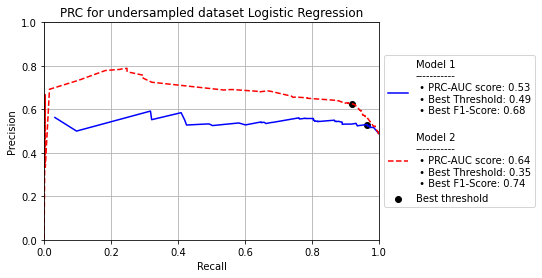

In [32]:
lr_best_threshold1, lr_best_threshold2, lr_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "undersampled dataset Logistic Regression")

Best Threshold=0.310922, F1-Score=0.749 for model 1
Best Threshold=0.480718, F1-Score=0.751 for model 2


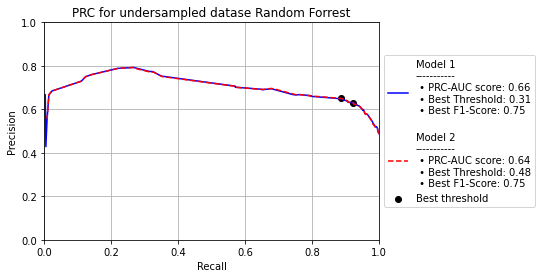

In [33]:
rf_best_threshold1, rf_best_threshold2, rf_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "undersampled datase Random Forrest")

Best Threshold=0.486212, F1-Score=0.750 for model 1
Best Threshold=0.484619, F1-Score=0.750 for model 2


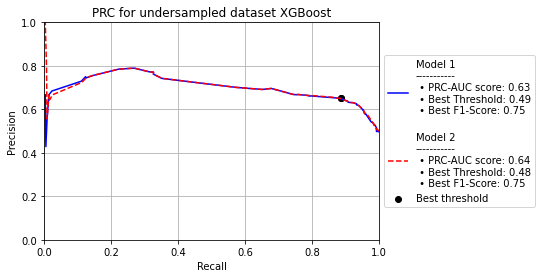

In [34]:
rf_best_threshold1, rf_best_threshold2, xgb_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "undersampled dataset XGBoost")

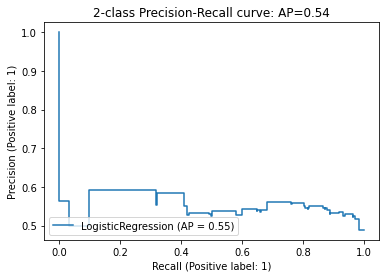

In [35]:
simple_threshold_plot(lr_model1, x1_test, y_test)

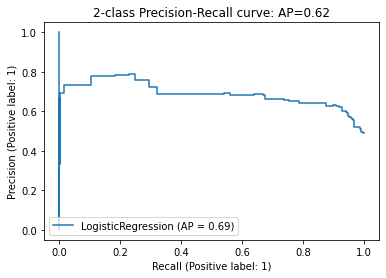

In [36]:
simple_threshold_plot(lr_model2, x2_test, y_test)

In [37]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[21][0] = "Undersampled_Logistic_Regression_Best_Threshold"
results_data[21][1] = lr_model1.score(x1_test, y_test)
results_data[21][2] = lr_model2.score(x2_test, y_test)
results_data[21][3] = acc1
results_data[21][4] = acc2
results_data[21][5] = prc_val1
results_data[21][6] = prc_val2
results_data[21][7] = pr_auc1
results_data[21][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[22][0] = "Undersampled_Random_Forrest_Best_Threshold"
results_data[22][1] = rf_model1.score(x1_test, y_test)
results_data[22][2] = rf_model2.score(x2_test, y_test)
results_data[22][3] = acc1
results_data[22][4] = acc2
results_data[22][5] = prc_val1
results_data[22][6] = prc_val2
results_data[22][7] = pr_auc1
results_data[22][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[23][0] = "Undersampled_XGB_Classifier_Best_Threshold"
results_data[23][1] = xgb_model1.score(x1_test, y_test)
results_data[23][2] = xgb_model2.score(x2_test, y_test)
results_data[23][3] = acc1
results_data[23][4] = acc2
results_data[23][5] = prc_val1
results_data[23][6] = prc_val2
results_data[23][7] = pr_auc1
results_data[23][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.5965984153037438
Average Precision-Recall Score: 0.5538997165475096
PRC-AUC for model 1: 0.5325544897732877
Accuracy: 0.565
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.18      0.30       583
           1       0.53      0.97      0.68       557

    accuracy                           0.56      1140
   macro avg       0.69      0.57      0.49      1140
weighted avg       0.69      0.56      0.49      1140


Scores for model 2
------------------
Roc_Auc Score: 0.7526090825945166
Average Precision-Recall Score: 0.6892414285977444
PRC-AUC for model 2: 0.6426255881330416
Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.48      0.61       583
           1       0.63      0.92      0.74       557

    accuracy                           0.69      1140
   macro avg       0.74      0.70      0.68      1140
weighted 

##### Cross Validation After Undersampling Rebalance for model 1

###### Repeated KFold

In [38]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, usx1, usy)
results_data[24][0] = "Undersampled_Logistic_Regression_rkf"
results_data[24][1] = model_score
results_data[24][3] = acc
results_data[24][5] = prc_val
results_data[24][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, usx1, usy, lr_best_threshold1)
results_data[25][0] = "Undersampled_Logistic_Regression_rkf_Best_Threshold"
results_data[25][1] = model_score
results_data[25][3] = acc
results_data[25][5] = prc_val
results_data[25][7] = pr_auc

Rkf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, usx1, usy)
results_data[26][0] = "Undersampled_Random_Forrest_rkf"
results_data[26][1] = model_score
results_data[26][3] = acc
results_data[26][5] = prc_val
results_data[26][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, usx1, usy)
results_data[27][0] = "Undersampled_XGB_Classifier_rkf"
results_data[27][1] = model_score
results_data[27][3] = acc
results_data[27][5] = prc_val
results_data[27][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    3 ... 3797 3798 3799] | TEST: [   2    6    8   13   20   23   37   39   53   71   83   86   91  105
  115  121  142  145  158  159  169  207  213  222  244  265  271  273
  277  287  292  294  306  308  311  316  339  348  352  377  382  394
  398  409  425  427  431  444  447  453  458  476  483  514  519  526
  548  552  556  571  579  583  585  588  590  591  634  672  674  686
  694  696  704  715  737  749  754  771  778  780  792  800  806  808
  824  849  861  873  885  886  888  892  902  906  908  913  917  923
  947  963  970  973  974  983  988  993 1007 1043 1050 1054 1083 1085
 1087 1096 1098 1109 1137 1165 1170 1189 1193 1199 1230 1245 1247 1259
 1265 1266 1274 1285 1290 1325 1328 1337 1343 1349 1355 1375 1380 1382
 1389 1393 1410 1413 1418 1435 1448 1453 1463 1486 1518 1530 1544 1547
 1559 1560 1562 1567 1576 1590 1591 1594 1596 1

In [39]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, usx1, usy)
results_data[28][0] = "Undersampled_Logistic_Regression_skf"
results_data[28][1] = model_score
results_data[28][3] = acc
results_data[28][5] = prc_val
results_data[28][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, usx1, usy, lr_best_threshold1)
results_data[29][0] = "Undersampled_Logistic_Regression_skf_Best_Threshold"
results_data[29][1] = model_score
results_data[29][3] = acc
results_data[29][5] = prc_val
results_data[29][7] = pr_auc

Skf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, usx1, usy)
results_data[30][0] = "Undersampled_Random_Forrest_skf"
results_data[30][1] = model_score
results_data[30][3] = acc
results_data[30][5] = prc_val
results_data[30][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, usx1, usy)
results_data[31][0] = "Undersampled_XGB_Classifier_skf"
results_data[31][1] = model_score
results_data[31][3] = acc
results_data[31][5] = prc_val
results_data[31][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [2607 2608 2609 2610 2613 2615 2617 2620 2621 2622 2624 2625 2628 2629
 2633 2635 2639 2641 2642 2643 2645 2646 2647 2648 2651 2652 2653 2654
 2661 2662 2663 2664 2666 2670 2673 2674 2675 2676 2677 2681 2682 2683
 2684 2687 2689 2695 2696 2697 2698 2701 2704 2706 2707 2708 2714 2715
 2716 2717 2718 2719 2720 2721 2722 2723 2724 2725 2726 2727 2728 2729
 2730 2731 2732 2733 2734 2735 2736 2737 2738 2739 2740 2741 2742 2743
 2744 2745 2746 2747 2748 2749 2750 2751 2752 2753 2754 2755 2756 2757
 2758 2759 2760 2761 2762 2763 2764 2765 2766 2767 2768 2769 2770 2771
 2772 2773 2774 2775 2776 2777 2778 2779 2780 2781 2782 2783 2784 2785
 2786 2787 2788 2789 2790 2791 2792 2793 2794 2795 2796 2797 2798 2799
 2800 2801 2802 2803 2804 2805 2806 2807 2808 2809 2810 2811 2812 2813
 2814 2815 2816 2817 2818 2819 2820 2821 2822 2

In [40]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, usx1, usy)
results_data[32][0] = "Undersampled_Logistic_Regression_tss"
results_data[32][1] = model_score
results_data[32][3] = acc
results_data[32][5] = prc_val
results_data[32][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, usx1, usy, lr_best_threshold1)
results_data[33][0] = "Undersampled_Logistic_Regression_tss_Best_Threshold"
results_data[33][1] = model_score
results_data[33][3] = acc
results_data[33][5] = prc_val
results_data[33][7] = pr_auc

Skf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Tss(rf_model1, usx1, usy)
results_data[34][0] = "Undersampled_Random_Forrest_tss"
results_data[34][1] = model_score
results_data[34][3] = acc
results_data[34][5] = prc_val
results_data[34][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, usx1, usy)
results_data[35][0] = "Undersampled_XGB_Classifier_tss"
results_data[35][1] = model_score
results_data[35][3] = acc
results_data[35][5] = prc_val
results_data[35][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 

Mean Average-Precision Recall Score: 0.5041859733305188
--------------------------------------
|Scores for Random Forrest Classifier|
--------------------------------------
With normal threshold
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196

##### Cross Validation After Undersampling Rebalance for model 2

In [41]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, usx2, usy)
results_data[24][2] = model_score
results_data[24][4] = acc
results_data[24][6] = prc_val
results_data[24][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, usx2, usy, lr_best_threshold2)
results_data[25][2] = model_score
results_data[25][4] = acc
results_data[25][6] = prc_val
results_data[25][8] = pr_auc

Rkf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, usx2, usy)
results_data[26][2] = model_score
results_data[26][4] = acc
results_data[26][6] = prc_val
results_data[26][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, usx2, usy)
results_data[27][2] = model_score
results_data[27][4] = acc
results_data[27][6] = prc_val
results_data[27][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    3 ... 3797 3798 3799] | TEST: [   2    6    8   13   20   23   37   39   53   71   83   86   91  105
  115  121  142  145  158  159  169  207  213  222  244  265  271  273
  277  287  292  294  306  308  311  316  339  348  352  377  382  394
  398  409  425  427  431  444  447  453  458  476  483  514  519  526
  548  552  556  571  579  583  585  588  590  591  634  672  674  686
  694  696  704  715  737  749  754  771  778  780  792  800  806  808
  824  849  861  873  885  886  888  892  902  906  908  913  917  923
  947  963  970  973  974  983  988  993 1007 1043 1050 1054 1083 1085
 1087 1096 1098 1109 1137 1165 1170 1189 1193 1199 1230 1245 1247 1259
 1265 1266 1274 1285 1290 1325 1328 1337 1343 1349 1355 1375 1380 1382
 1389 1393 1410 1413 1418 1435 1448 1453 1463 1486 1518 1530 1544 1547
 1559 1560 1562 1567 1576 1590 1591 1594 1596 1

In [42]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, usx2, usy)
results_data[28][2] = model_score
results_data[28][4] = acc
results_data[28][6] = prc_val
results_data[28][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, usx2, usy, lr_best_threshold2)
results_data[29][2] = model_score
results_data[29][4] = acc
results_data[29][6] = prc_val
results_data[29][8] = pr_auc

Skf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, usx2, usy)
results_data[30][2] = model_score
results_data[30][4] = acc
results_data[30][6] = prc_val
results_data[30][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model2, usx2, usy)
results_data[31][2] = model_score
results_data[31][4] = acc
results_data[31][6] = prc_val
results_data[31][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [2607 2608 2609 2610 2613 2615 2617 2620 2621 2622 2624 2625 2628 2629
 2633 2635 2639 2641 2642 2643 2645 2646 2647 2648 2651 2652 2653 2654
 2661 2662 2663 2664 2666 2670 2673 2674 2675 2676 2677 2681 2682 2683
 2684 2687 2689 2695 2696 2697 2698 2701 2704 2706 2707 2708 2714 2715
 2716 2717 2718 2719 2720 2721 2722 2723 2724 2725 2726 2727 2728 2729
 2730 2731 2732 2733 2734 2735 2736 2737 2738 2739 2740 2741 2742 2743
 2744 2745 2746 2747 2748 2749 2750 2751 2752 2753 2754 2755 2756 2757
 2758 2759 2760 2761 2762 2763 2764 2765 2766 2767 2768 2769 2770 2771
 2772 2773 2774 2775 2776 2777 2778 2779 2780 2781 2782 2783 2784 2785
 2786 2787 2788 2789 2790 2791 2792 2793 2794 2795 2796 2797 2798 2799
 2800 2801 2802 2803 2804 2805 2806 2807 2808 2809 2810 2811 2812 2813
 2814 2815 2816 2817 2818 2819 2820 2821 2822 2

In [43]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, usx2, usy)
results_data[32][2] = model_score
results_data[32][4] = acc
results_data[32][6] = prc_val
results_data[32][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, usx2, usy, lr_best_threshold2)
results_data[33][2] = model_score
results_data[33][4] = acc
results_data[33][6] = prc_val
results_data[33][8] = pr_auc

Skf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Tss(rf_model2, usx2, usy)
results_data[34][2] = model_score
results_data[34][4] = acc
results_data[34][6] = prc_val
results_data[34][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, usx2, usy)
results_data[35][2] = model_score
results_data[35][4] = acc
results_data[35][6] = prc_val
results_data[35][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 

Mean Average-Precision Recall Score: 0.4986632251580429
--------------------------------------
|Scores for Random Forrest Classifier|
--------------------------------------
With normal threshold
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196

Best Threshold=0.492241, F1-Score=0.710 for model 1
Best Threshold=0.242541, F1-Score=0.710 for model 2


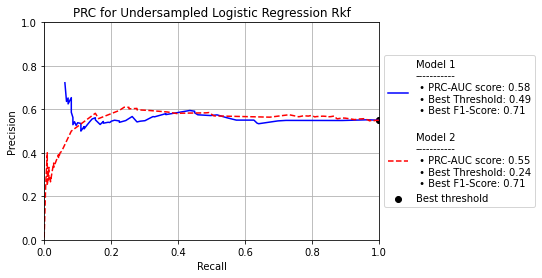

Best Threshold=0.000000, F1-Score=0.710 for model 1
Best Threshold=0.000000, F1-Score=0.710 for model 2


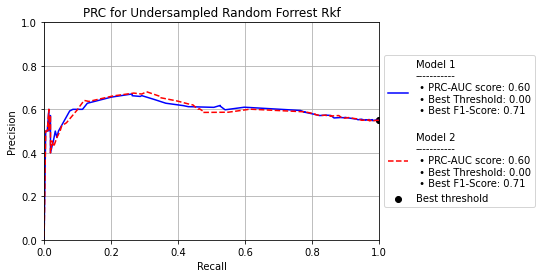

Best Threshold=0.026363, F1-Score=0.712 for model 1
Best Threshold=0.008901, F1-Score=0.710 for model 2


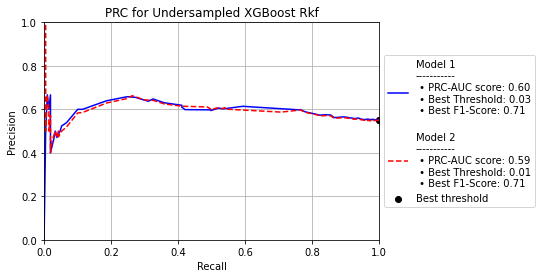

Best Threshold=0.481014, F1-Score=0.669 for model 1
Best Threshold=0.283267, F1-Score=0.673 for model 2


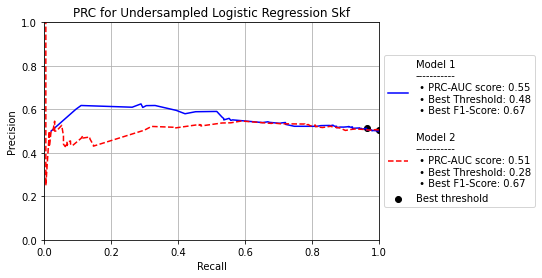

Best Threshold=0.147677, F1-Score=0.669 for model 1
Best Threshold=0.368926, F1-Score=0.675 for model 2


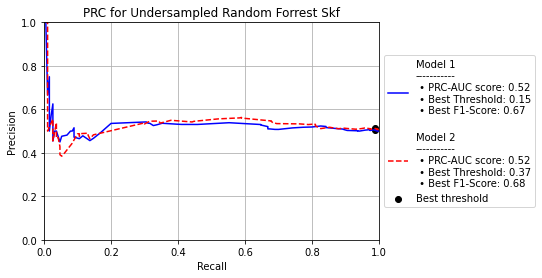

Best Threshold=0.379829, F1-Score=0.676 for model 1
Best Threshold=0.183639, F1-Score=0.675 for model 2


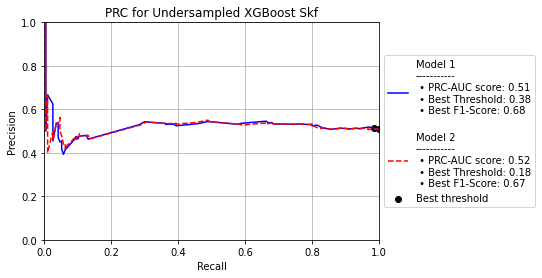

Best Threshold=0.478073, F1-Score=0.696 for model 1
Best Threshold=0.350936, F1-Score=0.693 for model 2


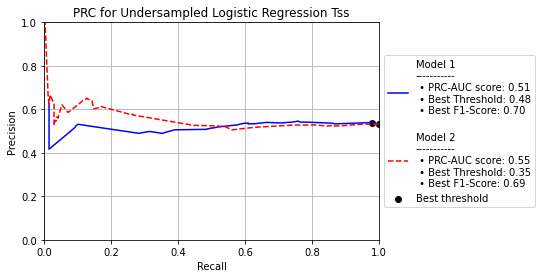

Best Threshold=0.191828, F1-Score=0.693 for model 1
Best Threshold=0.216127, F1-Score=0.693 for model 2


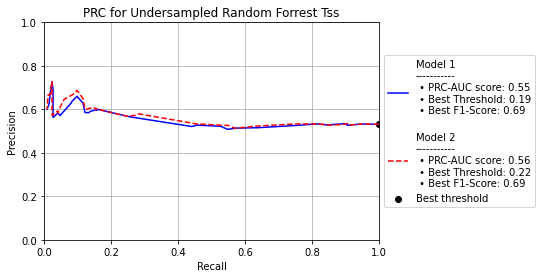

Best Threshold=0.042131, F1-Score=0.693 for model 1
Best Threshold=0.033024, F1-Score=0.693 for model 2


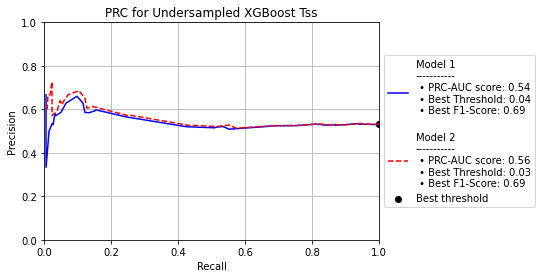

In [44]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "Undersampled Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "Undersampled Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "Undersampled XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "Undersampled Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "Undersampled Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "Undersampled XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "Undersampled Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "Undersampled Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "Undersampled XGBoost Tss")

#### Oversampling

In [45]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df["Bug"]

In [46]:
# For oversampling we will use SMOTE (Synthetic Minority Over-sampling Technique)

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

print("x1 Before SMOTE:")

print(x1_train.shape)

print("x2 Before SMOTE:")

print(x2_train.shape)

# Fit the model to generate the data for Model 1.
oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

# Fit the model to generate the data for Model 2.
oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

print("x1 After SMOTE:")

print(oversampled_X1.shape)

print("x2 After SMOTE:")

print(oversampled_X2.shape)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y2.value_counts(normalize=True) * 100)

osx1 = oversampled_X1
osx2 = oversampled_X2
osy1 = oversampled_Y1
osy2 = oversampled_Y2

x1 Before SMOTE:
(2660, 5)
x2 Before SMOTE:
(2660, 129)
x1 After SMOTE:
(555094, 5)
x2 After SMOTE:
(555094, 129)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [47]:
x1_train, x1_test, y1_train, y1_test = train_test_split(osx1, osy1, test_size=0.3, random_state = 5)
#x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
x2_train, x2_test, y2_train, y2_test = train_test_split(osx2, osy2, test_size=0.3, random_state = 5)
#x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
lr_model1.fit(x1_train, y1_train)
lr_model2.fit(x2_train, y2_train)
rf_model1.fit(x1_train, y1_train)
rf_model2.fit(x2_train, y2_train)
xgb_model1.fit(x1_train, y1_train)
xgb_model2.fit(x2_train, y2_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y1_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y2_test)}")
results_data[36][0] = "Oversampled_Logistic_Regression"
results_data[36][1] = lr_model1.score(x1_test, y1_test)
results_data[36][2] = lr_model2.score(x2_test, y2_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y1_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y2_test)}")
results_data[37][0] = "Oversampled_Random_Forrest"
results_data[37][1] = rf_model1.score(x1_test, y1_test)
results_data[37][2] = rf_model2.score(x2_test, y2_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y1_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y2_test)}")
results_data[38][0] = "Oversampled_XGB_Classifier"
results_data[38][1] = xgb_model1.score(x1_test, y1_test)
results_data[38][2] = xgb_model2.score(x2_test, y2_test)

Logistic regression training score for model 1: 0.5921311002888385
Logistic regression training score for model 2: 0.7130529817629362
Random Forrest Classification training score for model 1: 0.7142059341015679
Random Forrest Classification training score for model 2: 0.7141819142611797
XGB Classifier training score for model 1: 0.7141699043409857
XGB Classifier training score for model 2: 0.7141759093010827


In [48]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[36][3] = acc1
results_data[36][4] = acc2
results_data[36][5] = prc_val1
results_data[36][6] = prc_val2
results_data[36][7] = pr_auc1
results_data[36][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[37][3] = acc1
results_data[37][4] = acc2
results_data[37][5] = prc_val1
results_data[37][6] = prc_val2
results_data[37][7] = pr_auc1
results_data[37][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[38][3] = acc1
results_data[38][4] = acc2
results_data[38][5] = prc_val1
results_data[38][6] = prc_val2
results_data[38][7] = pr_auc1
results_data[38][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.6054327561508921
Average Precision-Recall Score: 0.573570009921337
PRC-AUC for model 1: 0.5742643009934064
Accuracy: 0.592
Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.33      0.44     83150
           1       0.56      0.86      0.68     83379

    accuracy                           0.59    166529
   macro avg       0.63      0.59      0.56    166529
weighted avg       0.63      0.59      0.56    166529


Scores for model 2
------------------
Roc_Auc Score: 0.7769402289613841
Average Precision-Recall Score: 0.7360701518855101
PRC-AUC for model 2: 0.7483999505517098
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.54      0.65     83150
           1       0.66      0.88      0.75     83379

    accuracy       

In [49]:
y1_test.value_counts()

1    83379
0    83150
Name: Bug, dtype: int64

###### Compare Precision-Recall thresholds between models for oversampling

Best Threshold=0.490205, F1-Score=0.690 for model 1
Best Threshold=0.438525, F1-Score=0.760 for model 2


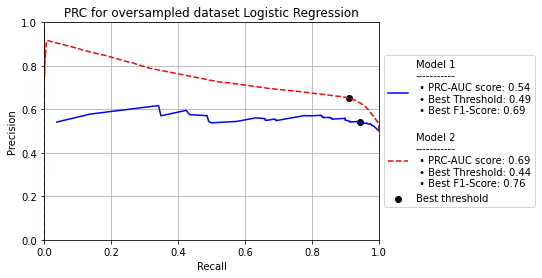

In [50]:
lr_best_threshold1, lr_best_threshold2, lr_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_test, x2_test, y2_test, lr_prediction_probs1, lr_prediction_probs2, "oversampled dataset Logistic Regression")

Best Threshold=0.412301, F1-Score=0.761 for model 1
Best Threshold=0.392510, F1-Score=0.761 for model 2


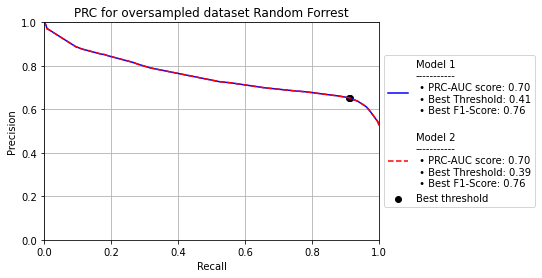

In [51]:
rf_best_threshold1, rf_best_threshold2, rf_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_test, x2_test, y2_test, rf_prediction_probs1, rf_prediction_probs2, "oversampled dataset Random Forrest")

Best Threshold=0.393469, F1-Score=0.761 for model 1
Best Threshold=0.397762, F1-Score=0.761 for model 2


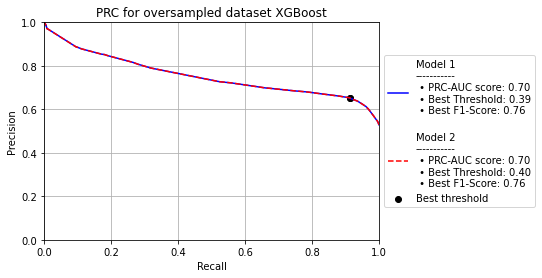

In [52]:
xgb_best_threshold1, xgb_best_threshold2, xgb_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_test, x2_test, y2_test, xgb_prediction_probs1, xgb_prediction_probs2, "oversampled dataset XGBoost")

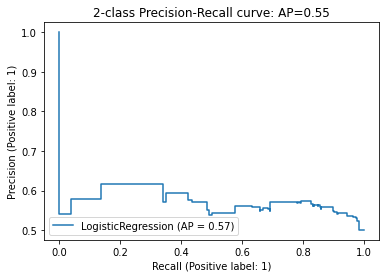

In [53]:
simple_threshold_plot(lr_model1, x1_test, y1_test)

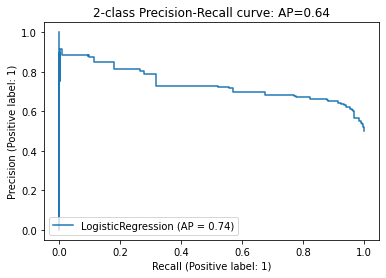

In [54]:
simple_threshold_plot(lr_model2, x2_test, y2_test)

Using best threshold...

In [55]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[39][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[39][1] = lr_model1.score(x1_test, y1_test)
results_data[39][2] = lr_model2.score(x2_test, y2_test)
results_data[39][3] = acc1
results_data[39][4] = acc2
results_data[39][5] = prc_val1
results_data[39][6] = prc_val2
results_data[39][7] = pr_auc1
results_data[39][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[40][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[40][1] = rf_model1.score(x1_test, y1_test)
results_data[40][2] = rf_model2.score(x2_test, y2_test)
results_data[40][3] = acc1
results_data[40][4] = acc2
results_data[40][5] = prc_val1
results_data[40][6] = prc_val2
results_data[40][7] = pr_auc1
results_data[40][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[41][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[41][1] = xgb_model1.score(x1_test, y1_test)
results_data[41][2] = xgb_model2.score(x2_test, y2_test)
results_data[41][3] = acc1
results_data[41][4] = acc2
results_data[41][5] = prc_val1
results_data[41][6] = prc_val2
results_data[41][7] = pr_auc1
results_data[41][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.6054327561508921
Average Precision-Recall Score: 0.573570009921337
PRC-AUC for model 1: 0.5445564252858643
Accuracy: 0.576
Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.21      0.33     83150
           1       0.54      0.94      0.69     83379

    accuracy                           0.58    166529
   macro avg       0.66      0.58      0.51    166529
weighted avg       0.66      0.58      0.51    166529


Scores for model 2
------------------
Roc_Auc Score: 0.7769402289613841
Average Precision-Recall Score: 0.7360701518855101
PRC-AUC for model 2: 0.6942381558740742
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.51      0.64     83150
           1       0.65      0.91      0.76     83379

    accuracy                           0.71    166529
   macro avg       0.75      0.71      0.70    166529
weighted a

##### Cross Validation After Oversampling Rebalance for model 1

In [56]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, osx1, osy1)
results_data[42][0] = "Oversampled_Logistic_Regression_rkf"
results_data[42][1] = model_score
results_data[42][3] = acc
results_data[42][5] = prc_val
results_data[42][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, osx1, osy1, lr_best_threshold1)
results_data[43][0] = "Oversampled_Logistic_Regression_rkf_Best_Threshold"
results_data[43][1] = model_score
results_data[43][3] = acc
results_data[43][5] = prc_val
results_data[43][7] = pr_auc

Rkf_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, osx1, osy1)
results_data[44][0] = "Oversampled_Random_Forrest_rkf"
results_data[44][1] = model_score
results_data[44][3] = acc
results_data[44][5] = prc_val
results_data[44][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, osx1, osy1)
results_data[45][0] = "Oversampled_XGB_Classifier_rkf"
results_data[45][1] = model_score
results_data[45][3] = acc
results_data[45][5] = prc_val
results_data[45][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 555091 555092 555093] | TEST: [     4      9     11 ... 555075 555078 555079]

Model Score: 0.5949845970923634
Average Precision-Recall Score: 0.5557583376365359
PRC-AUC Score: 0.5493140425609606
Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.33      0.45     27555
           1       0.56      0.86      0.68     27954

    accuracy                           0.59     55509
   macro avg       0.63      0.59      0.56     55509
weighted avg       0.63      0.59      0.56     55509

Accuracy: 0.595
---------------------
With best threshold
TRAIN: [     0      1      2 ... 555091 555092 555093] | TEST: [     4      9     11 ... 555075 555078 555079]

Model Score: 0.5949845970923634
Average Precision-Recall Score: 0.5557583376365359
PRC-AUC Score: 0.7299245558656761
Classificati

In [57]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, osx1, osy1)
results_data[46][0] = "Oversampled_Logistic_Regression_skf"
results_data[46][1] = model_score
results_data[46][3] = acc
results_data[46][5] = prc_val
results_data[46][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, osx1, osy1, lr_best_threshold1)
results_data[47][0] = "Oversampled_Logistic_Regression_skf_Best_Threshold"
results_data[47][1] = model_score
results_data[47][3] = acc
results_data[47][5] = prc_val
results_data[47][7] = pr_auc

Skf_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, osx1, osy1)
results_data[48][0] = "Oversampled_Random_Forrest_skf"
results_data[48][1] = model_score
results_data[48][3] = acc
results_data[48][5] = prc_val
results_data[48][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, osx1, osy1)
results_data[49][0] = "Oversampled_XGB_Classifier_skf"
results_data[49][1] = model_score
results_data[49][3] = acc
results_data[49][5] = prc_val
results_data[49][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 555091 555092 555093] | TEST: [231646 231647 231648 ... 499581 499582 499583]

Model Score: 0.7795852924750941

Average Precision-Recall Score: 0.7088391950406011
PRC-AUC Score: 0.7794473673199839
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.71      0.76     27754
           1       0.75      0.85      0.79     27755

    accuracy                           0.78     55509
   macro avg       0.78      0.78      0.78     55509
weighted avg       0.78      0.78      0.78     55509

Accuracy: 0.780
---------------------
With best threshold
TRAIN: [     0      1      2 ... 555091 555092 555093] | TEST: [231646 231647 231648 ... 499581 499582 499583]

Model Score: 0.7795852924750941

Average Precision-Recall Score: 0.7088391950406011
PRC-AUC Score: 0.7236251007142529
Classifica

In [58]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, osx1, osy1)
results_data[50][0] = "Oversampled_Logistic_Regression_tss"
results_data[50][1] = model_score
results_data[50][3] = acc
results_data[50][5] = prc_val
results_data[50][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, osx1, osy1, lr_best_threshold1)
results_data[51][0] = "Oversampled_Logistic_Regression_tss_Best_Threshold"
results_data[51][1] = model_score
results_data[51][3] = acc
results_data[51][5] = prc_val
results_data[51][7] = pr_auc

Tss_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Tss(rf_model1, osx1, osy1)
results_data[52][0] = "Oversampled_Random_Forrest_tss"
results_data[52][1] = model_score
results_data[52][3] = acc
results_data[52][5] = prc_val
results_data[52][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, osx1, osy1)
results_data[53][0] = "Oversampled_XGB_Classifier_tss"
results_data[53][1] = model_score
results_data[53][3] = acc
results_data[53][5] = prc_val
results_data[53][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 370061 370062 370063] | TEST: [370064 370065 370066 ... 462576 462577 462578]

Model Score: 0.007555531535426687

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0000000000000002
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.01      0.01     92515

    accuracy                           0.01     92515
   macro avg       0.50      0.00      0.01     92515
weighted avg       1.00      0.01      0.01     92515

Accuracy: 0.008
---------------------
With best threshold
TRAIN: [     0      1      2 ... 370061 370062 370063] | TEST: [370064 370065 370066 ... 462576 462577 462578]

Model Score: 0.007555531535426687

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    

##### Cross Validation After Oversampling Rebalance for model 2

In [59]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, osx2, osy2)
results_data[42][2] = model_score
results_data[42][4] = acc
results_data[42][6] = prc_val
results_data[42][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, osx2, osy2, lr_best_threshold2)
results_data[43][2] = model_score
results_data[43][4] = acc
results_data[43][6] = prc_val
results_data[43][8] = pr_auc

Rkf_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, osx2, osy2)
results_data[44][2] = model_score
results_data[44][4] = acc
results_data[44][6] = prc_val
results_data[44][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, osx2, osy2)
results_data[45][2] = model_score
results_data[45][4] = acc
results_data[45][6] = prc_val
results_data[45][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 555091 555092 555093] | TEST: [     4      9     11 ... 555075 555078 555079]

Model Score: 0.715955971103785
Average Precision-Recall Score: 0.6452209122961078
PRC-AUC Score: 0.69734182890005
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.55      0.66     27555
           1       0.66      0.88      0.76     27954

    accuracy                           0.72     55509
   macro avg       0.74      0.71      0.71     55509
weighted avg       0.74      0.72      0.71     55509

Accuracy: 0.716
---------------------
With best threshold
TRAIN: [     0      1      2 ... 555091 555092 555093] | TEST: [     4      9     11 ... 555075 555078 555079]

Model Score: 0.715955971103785
Average Precision-Recall Score: 0.6452209122961078
PRC-AUC Score: 0.7538369545138163
Classification R

In [60]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, osx2, osy2)
results_data[46][2] = model_score
results_data[46][4] = acc
results_data[46][6] = prc_val
results_data[46][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, osx2, osy2, lr_best_threshold2)
results_data[47][2] = model_score
results_data[47][4] = acc
results_data[47][6] = prc_val
results_data[47][8] = pr_auc

Skf_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, osx2, osy2)
results_data[48][2] = model_score
results_data[48][4] = acc
results_data[48][6] = prc_val
results_data[48][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model1, osx1, osy1)
results_data[49][2] = model_score
results_data[49][4] = acc
results_data[49][6] = prc_val
results_data[49][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 555091 555092 555093] | TEST: [199411 199412 199413 ... 471826 471827 471828]

Model Score: 0.5756183681925453

Average Precision-Recall Score: 0.5413063208455023
PRC-AUC Score: 0.34592149597034644
Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.26      0.38     27755
           1       0.55      0.89      0.68     27754

    accuracy                           0.58     55509
   macro avg       0.63      0.58      0.53     55509
weighted avg       0.63      0.58      0.53     55509

Accuracy: 0.576
---------------------
With best threshold
TRAIN: [     0      1      2 ... 555091 555092 555093] | TEST: [199411 199412 199413 ... 471826 471827 471828]

Model Score: 0.5756183681925453

Average Precision-Recall Score: 0.5413063208455023
PRC-AUC Score: 0.715045042805166
Classifica

In [61]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, osx2, osy2)
results_data[50][2] = model_score
results_data[50][4] = acc
results_data[50][6] = prc_val
results_data[50][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, osx2, osy2, lr_best_threshold2)
results_data[51][2] = model_score
results_data[51][4] = acc
results_data[51][6] = prc_val
results_data[51][8] = pr_auc

Tss_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Tss(rf_model2, osx2, osy2)
results_data[52][2] = model_score
results_data[52][4] = acc
results_data[52][6] = prc_val
results_data[52][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, osx2, osy2)
results_data[53][2] = model_score
results_data[53][4] = acc
results_data[53][6] = prc_val
results_data[53][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 370061 370062 370063] | TEST: [370064 370065 370066 ... 462576 462577 462578]

Model Score: 0.18055450467491757

Average Precision-Recall Score: 1.0
PRC-AUC Score: 0.9999999999999999
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.18      0.31     92515

    accuracy                           0.18     92515
   macro avg       0.50      0.09      0.15     92515
weighted avg       1.00      0.18      0.31     92515

Accuracy: 0.181
---------------------
With best threshold
TRAIN: [     0      1      2 ... 370061 370062 370063] | TEST: [370064 370065 370066 ... 462576 462577 462578]

Model Score: 0.18055450467491757

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    re

Best Threshold=0.491268, F1-Score=0.693 for model 1
Best Threshold=0.440022, F1-Score=0.762 for model 2


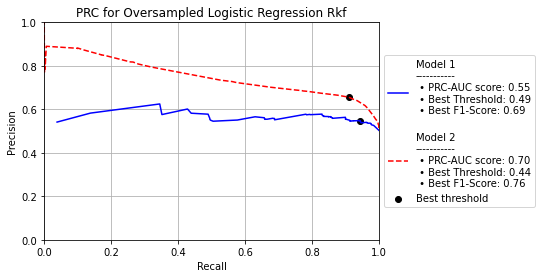

Best Threshold=0.412570, F1-Score=0.763 for model 1
Best Threshold=0.429022, F1-Score=0.763 for model 2


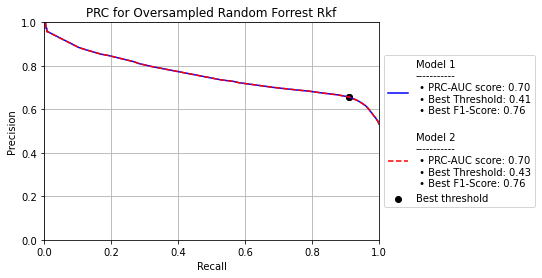

Best Threshold=0.429779, F1-Score=0.763 for model 1
Best Threshold=0.411470, F1-Score=0.763 for model 2


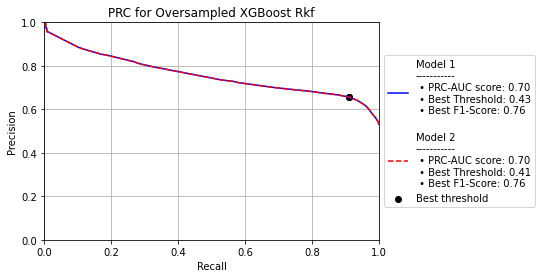

Best Threshold=0.503478, F1-Score=0.840 for model 1
Best Threshold=0.235037, F1-Score=0.706 for model 2


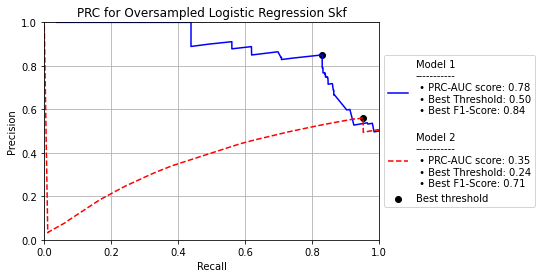

Best Threshold=0.313187, F1-Score=0.681 for model 1
Best Threshold=0.383594, F1-Score=0.710 for model 2


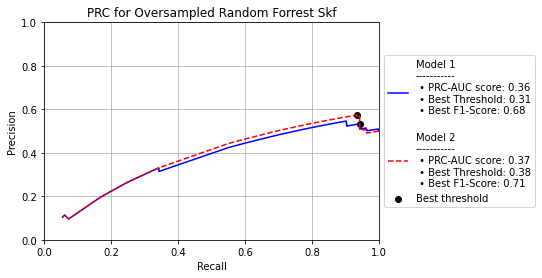

Best Threshold=0.313820, F1-Score=0.700 for model 1
Best Threshold=0.313820, F1-Score=0.700 for model 2


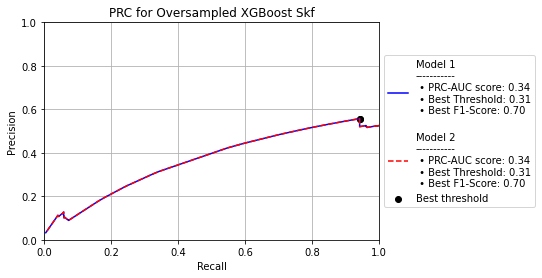

Best Threshold=0.053231, F1-Score=1.000 for model 1
Best Threshold=0.000000, F1-Score=1.000 for model 2


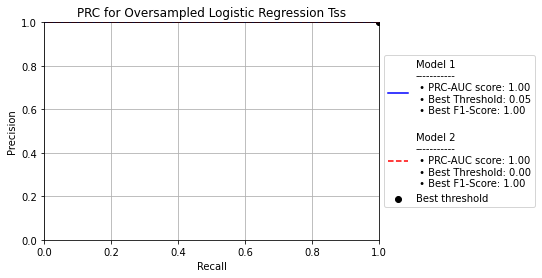

Best Threshold=0.006384, F1-Score=1.000 for model 1
Best Threshold=0.014667, F1-Score=1.000 for model 2


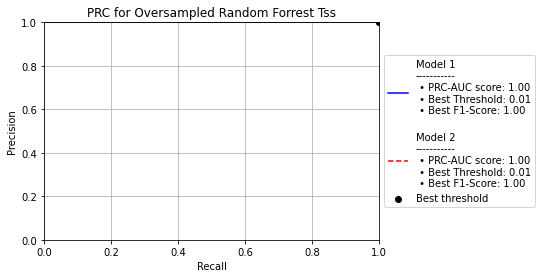

Best Threshold=0.000863, F1-Score=1.000 for model 1
Best Threshold=0.001579, F1-Score=1.000 for model 2


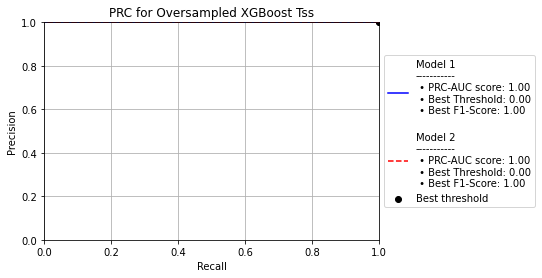

In [62]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "Oversampled Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "Oversampled Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "Oversampled XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "Oversampled Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "Oversampled Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "Oversampled XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "Oversampled Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "Oversampled Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "Oversampled XGBoost Tss")

##### Combining Oversampling with Undersampling

In [63]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df["Bug"]

In [64]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
print("x1 Before SMOTE:")
print(x1.shape)
print("x2 Before SMOTE:")
print(x2.shape)

# Fit the model to generate the data for Model 1.
oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

# Fit the model to generate the data for Model 2.
oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

print("x1 After SMOTE:")
print(oversampled_X1.shape)
print("x2 After SMOTE:")
print(oversampled_X2.shape)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y2.value_counts(normalize=True) * 100)

osx1 = oversampled_X1
osx2 = oversampled_X2
osy1 = oversampled_Y1
osy2 = oversampled_Y2

x1 Before SMOTE:
(349178, 5)
x2 Before SMOTE:
(349178, 129)
x1 After SMOTE:
(555094, 5)
x2 After SMOTE:
(555094, 129)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [65]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

print("x1 Before RandomUnderSampler:")
print(osx1.shape)
print("x2 Before RandomUnderSampler:")
print(osx2.shape)

balanced_x1, balanced_y1, = rus.fit_resample(osx1, osy1)
balanced_x2, balanced_y2, = rus.fit_resample(osx2, osy2)

print("x1 After RandomUnderSampler:")
print(balanced_x1.shape)
print("x2 After RandomUnderSampler:")
print(balanced_x1.shape)

print('\nBalance of positive and negative classes (%):')
print(balanced_y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(balanced_y2.value_counts(normalize=True) * 100)

x1 Before RandomUnderSampler:
(555094, 5)
x2 Before RandomUnderSampler:
(555094, 129)
x1 After RandomUnderSampler:
(555094, 5)
x2 After RandomUnderSampler:
(555094, 5)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [66]:
x1_train, x1_test, y1_train, y1_test = train_test_split(balanced_x1, balanced_y1, test_size=0.3, random_state = 5)
#x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
x2_train, x2_test, y2_train, y2_test = train_test_split(balanced_x2, balanced_y2, test_size=0.3, random_state = 5)
#x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
lr_model1.fit(x1_train, y1_train)
lr_model2.fit(x2_train, y2_train)
rf_model1.fit(x1_train, y1_train)
rf_model2.fit(x2_train, y2_train)
xgb_model1.fit(x1_train, y1_train)
xgb_model2.fit(x2_train, y2_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y1_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y2_test)}")
results_data[54][0] = "OSUS_Combination_Logistic_Regression"
results_data[54][1] = lr_model1.score(x1_test, y1_test)
results_data[54][2] = lr_model2.score(x2_test, y2_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y1_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y2_test)}")
results_data[55][0] = "OSUS_Combination_Random_Forrest"
results_data[55][1] = rf_model1.score(x1_test, y1_test)
results_data[55][2] = rf_model2.score(x2_test, y2_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y1_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y2_test)}")
results_data[56][0] = "OSUS_Combination_XGB_Classifier"
results_data[56][1] = xgb_model1.score(x1_test, y1_test)
results_data[56][2] = xgb_model2.score(x2_test, y2_test)

Logistic regression training score for model 1: 0.5910261876309832
Logistic regression training score for model 2: 0.7120741732671186
Random Forrest Classification training score for model 1: 0.7137975968149691
Random Forrest Classification training score for model 2: 0.7136534777726402
XGB Classifier training score for model 1: 0.713773576974581
XGB Classifier training score for model 2: 0.7136294579322521


In [67]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[54][3] = acc1
results_data[54][4] = acc2
results_data[54][5] = prc_val1
results_data[54][6] = prc_val2
results_data[54][7] = pr_auc1
results_data[54][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[55][3] = acc1
results_data[55][4] = acc2
results_data[55][5] = prc_val1
results_data[55][6] = prc_val2
results_data[55][7] = pr_auc1
results_data[55][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[56][3] = acc1
results_data[56][4] = acc2
results_data[56][5] = prc_val1
results_data[56][6] = prc_val2
results_data[56][7] = pr_auc1
results_data[56][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.6068173446373484
Average Precision-Recall Score: 0.5741556016793865
PRC-AUC for model 1: 0.575451690666767
Accuracy: 0.591
Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.32      0.44     83297
           1       0.56      0.86      0.68     83232

    accuracy                           0.59    166529
   macro avg       0.63      0.59      0.56    166529
weighted avg       0.63      0.59      0.56    166529


Scores for model 2
------------------
Roc_Auc Score: 0.7762350877918183
Average Precision-Recall Score: 0.7345742547364205
PRC-AUC for model 2: 0.7443476882526743
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.54      0.65     83297
           1       0.66      0.88      0.75     83232

    accuracy       

###### Compare Precision-Recall thresholds between models for oversampling and undersampling combination

Best Threshold=0.491348, F1-Score=0.690 for model 1
Best Threshold=0.405856, F1-Score=0.760 for model 2


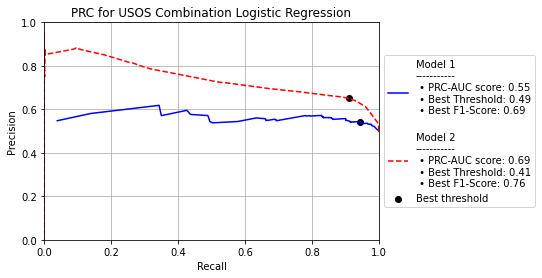

In [68]:
lr_best_threshold1, lr_best_threshold2, lr_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_test, x2_test, y2_test, lr_prediction_probs1, lr_prediction_probs2, "USOS Combination Logistic Regression")

Best Threshold=0.398499, F1-Score=0.761 for model 1
Best Threshold=0.400039, F1-Score=0.761 for model 2


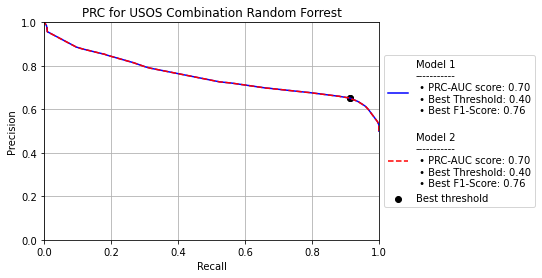

In [69]:
rf_best_threshold1, rf_best_threshold2, rf_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_test, x2_test, y2_test, rf_prediction_probs1, rf_prediction_probs2, "USOS Combination Random Forrest")

Best Threshold=0.394458, F1-Score=0.761 for model 1
Best Threshold=0.398884, F1-Score=0.761 for model 2


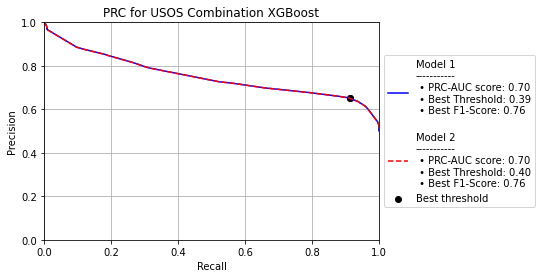

In [70]:
xgb_best_threshold1, xgb_best_threshold2, xgb_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_test, x2_test, y2_test, xgb_prediction_probs1, xgb_prediction_probs2, "USOS Combination XGBoost")

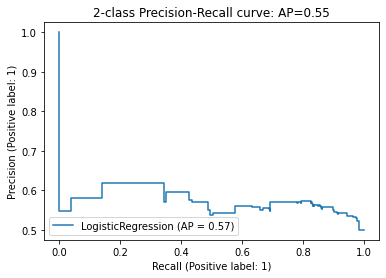

In [71]:
simple_threshold_plot(lr_model1, x1_test, y1_test)

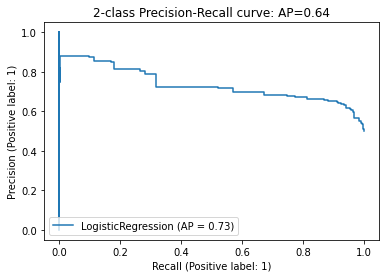

In [72]:
simple_threshold_plot(lr_model2, x2_test, y2_test)

Using the best threshold...

In [73]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[57][0] = "OSUS_Logistic_Regression_Best_Threshold"
results_data[57][1] = lr_model1.score(x1_test, y1_test)
results_data[57][2] = lr_model2.score(x2_test, y2_test)
results_data[57][3] = acc1
results_data[57][4] = acc2
results_data[57][5] = prc_val1
results_data[57][6] = prc_val2
results_data[57][7] = pr_auc1
results_data[57][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[58][0] = "OSUS_Random_Forrest_Best_Threshold"
results_data[58][1] = rf_model1.score(x1_test, y1_test)
results_data[58][2] = rf_model2.score(x2_test, y2_test)
results_data[58][3] = acc1
results_data[58][4] = acc2
results_data[58][5] = prc_val1
results_data[58][6] = prc_val2
results_data[58][7] = pr_auc1
results_data[58][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[59][0] = "OSUS_XGBoost_Classifier_Best_Threshold"
results_data[59][1] = xgb_model1.score(x1_test, y1_test)
results_data[59][2] = xgb_model2.score(x2_test, y2_test)
results_data[59][3] = acc1
results_data[59][4] = acc2
results_data[59][5] = prc_val1
results_data[59][6] = prc_val2
results_data[59][7] = pr_auc1
results_data[59][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.6068173446373484
Average Precision-Recall Score: 0.5741556016793865
PRC-AUC for model 1: 0.5464215147095778
Accuracy: 0.575
Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.21      0.33     83297
           1       0.54      0.94      0.69     83232

    accuracy                           0.58    166529
   macro avg       0.67      0.58      0.51    166529
weighted avg       0.67      0.58      0.51    166529


Scores for model 2
------------------
Roc_Auc Score: 0.7762350877918183
Average Precision-Recall Score: 0.7345742547364205
PRC-AUC for model 2: 0.6909271784723897
Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.51      0.64     83297
           1       0.65      0.91      0.76     83232

    accuracy                           0.71    166529
   macro avg       0.75      0.71      0.70    166529
weighted 

##### Cross Validation After Oversampling/Undersampling Combination Rebalance for model 1

In [74]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, balanced_x1, balanced_y1)
results_data[60][0] = "OSUS_Combination_Logistic_Regression_rkf"
results_data[60][1] = model_score
results_data[60][3] = acc
results_data[60][5] = prc_val
results_data[60][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
results_data[61][0] = "OSUS_Combination_Logistic_Regression_rkf_Best_Threshold"
results_data[61][1] = model_score
results_data[61][3] = acc
results_data[61][5] = prc_val
results_data[61][7] = pr_auc

Rkf_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, balanced_x1, balanced_y1)
results_data[62][0] = "OSUS_Combination_Random_Forrest_rkf"
results_data[62][1] = model_score
results_data[62][3] = acc
results_data[62][5] = prc_val
results_data[62][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, balanced_x1, balanced_y1)
results_data[63][0] = "OSUS_Combination_XGB_Classifier_rkf"
results_data[63][1] = model_score
results_data[63][3] = acc
results_data[63][5] = prc_val
results_data[63][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 555091 555092 555093] | TEST: [    10     11     28 ... 555051 555053 555086]

Model Score: 0.5948657899477572
Average Precision-Recall Score: 0.5550687347289815
PRC-AUC Score: 0.5288157830906394
Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.33      0.45     27606
           1       0.56      0.86      0.68     27904

    accuracy                           0.59     55510
   macro avg       0.63      0.59      0.56     55510
weighted avg       0.63      0.59      0.56     55510

Accuracy: 0.595
---------------------
With best threshold
TRAIN: [     0      1      2 ... 555091 555092 555093] | TEST: [    10     11     28 ... 555051 555053 555086]

Model Score: 0.5948657899477572
Average Precision-Recall Score: 0.5550687347289815
PRC-AUC Score: 0.729897785834477
Classificatio

In [75]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, balanced_x1, balanced_y1)
results_data[64][0] = "OSUS_Combination_Logistic_Regression_skf"
results_data[64][1] = model_score
results_data[64][3] = acc
results_data[64][5] = prc_val
results_data[64][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
results_data[65][0] = "OSUS_Combination_Logistic_Regression_skf_Best_Threshold"
results_data[65][1] = model_score
results_data[65][3] = acc
results_data[65][5] = prc_val
results_data[65][7] = pr_auc

Skf_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, balanced_x1, balanced_y1)
results_data[66][0] = "OSUS_Combination_Random_Forrest_skf"
results_data[66][1] = model_score
results_data[66][3] = acc
results_data[66][5] = prc_val
results_data[66][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, balanced_x1, balanced_y1)
results_data[67][0] = "OSUS_Combination_XGB_Classifier_skf"
results_data[67][1] = model_score
results_data[67][3] = acc
results_data[67][5] = prc_val
results_data[67][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 555091 555092 555093] | TEST: [194285 194286 194287 ... 499581 499582 499583]

Model Score: 0.7774234808769749

Average Precision-Recall Score: 0.7069553887901401
PRC-AUC Score: 0.7751223502097753
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.71      0.76     27754
           1       0.75      0.84      0.79     27755

    accuracy                           0.78     55509
   macro avg       0.78      0.78      0.78     55509
weighted avg       0.78      0.78      0.78     55509

Accuracy: 0.777
---------------------
With best threshold
TRAIN: [     0      1      2 ... 555091 555092 555093] | TEST: [194285 194286 194287 ... 499581 499582 499583]

Model Score: 0.7774234808769749

Average Precision-Recall Score: 0.7069553887901401
PRC-AUC Score: 0.7050701919763697
Classifica

In [76]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, balanced_x1, balanced_y1)
results_data[68][0] = "OSUS_Combination_Logistic_Regression_tss"
results_data[68][1] = model_score
results_data[68][3] = acc
results_data[68][5] = prc_val
results_data[68][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
results_data[69][0] = "OSUS_Combination_Logistic_Regression_tss_Best_Threshold"
results_data[69][1] = model_score
results_data[69][3] = acc
results_data[69][5] = prc_val
results_data[69][7] = pr_auc

Tss_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Skf(rf_model1, balanced_x1, balanced_y1)
results_data[70][0] = "OSUS_Combination_Random_Forrest_tss"
results_data[70][1] = model_score
results_data[70][3] = acc
results_data[70][5] = prc_val
results_data[70][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, balanced_x1, balanced_y1)
results_data[71][0] = "OSUS_Combination_XGB_Classifier_tss"
results_data[71][1] = model_score
results_data[71][3] = acc
results_data[71][5] = prc_val
results_data[71][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 277546 277547 277548] | TEST: [277549 277550 277551 ... 370061 370062 370063]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 0.9999999999999998
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   92515.0

    accuracy                           0.00   92515.0
   macro avg       0.00      0.00      0.00   92515.0
weighted avg       0.00      0.00      0.00   92515.0

Accuracy: 0.000
---------------------
With best threshold
TRAIN: [     0      1      2 ... 277546 277547 277548] | TEST: [277549 277550 277551 ... 370061 370062 370063]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

      

##### Cross Validation After Oversampling/Undersampling Combination Rebalance for model 2

In [77]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, balanced_x2, balanced_y2)
results_data[60][2] = model_score
results_data[60][4] = acc
results_data[60][6] = prc_val
results_data[60][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
results_data[61][2] = model_score
results_data[61][4] = acc
results_data[61][6] = prc_val
results_data[61][8] = pr_auc

Rkf_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, balanced_x2, balanced_y2)
results_data[62][2] = model_score
results_data[62][4] = acc
results_data[62][6] = prc_val
results_data[62][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, balanced_x2, balanced_y2)
results_data[63][2] = model_score
results_data[63][4] = acc
results_data[63][6] = prc_val
results_data[63][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      2      3 ... 555091 555092 555093] | TEST: [     1     12     21 ... 555073 555080 555086]

Model Score: 0.7166456494325347
Average Precision-Recall Score: 0.6448665815266543
PRC-AUC Score: 0.6993461590514392
Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.55      0.66     27621
           1       0.66      0.89      0.76     27889

    accuracy                           0.72     55510
   macro avg       0.74      0.72      0.71     55510
weighted avg       0.74      0.72      0.71     55510

Accuracy: 0.717
---------------------
With best threshold
TRAIN: [     0      2      3 ... 555091 555092 555093] | TEST: [     1     12     21 ... 555073 555080 555086]

Model Score: 0.7166456494325347
Average Precision-Recall Score: 0.6448665815266543
PRC-AUC Score: 0.7556792069883466
Classificati

In [78]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, balanced_x2, balanced_y2)
results_data[64][2] = model_score
results_data[64][4] = acc
results_data[64][6] = prc_val
results_data[64][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
results_data[65][2] = model_score
results_data[65][4] = acc
results_data[65][6] = prc_val
results_data[65][8] = pr_auc

Skf_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, balanced_x2, balanced_y2)
results_data[66][2] = model_score
results_data[66][4] = acc
results_data[66][6] = prc_val
results_data[66][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model2, balanced_x2, balanced_y2)
results_data[67][2] = model_score
results_data[67][4] = acc
results_data[67][6] = prc_val
results_data[67][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 555091 555092 555093] | TEST: [166530 166531 166532 ... 471826 471827 471828]

Model Score: 0.5747896737465996

Average Precision-Recall Score: 0.5408190894210756
PRC-AUC Score: 0.32830617029495635
Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.26      0.38     27755
           1       0.55      0.89      0.68     27754

    accuracy                           0.57     55509
   macro avg       0.62      0.57      0.53     55509
weighted avg       0.62      0.57      0.53     55509

Accuracy: 0.575
---------------------
With best threshold
TRAIN: [     0      1      2 ... 555091 555092 555093] | TEST: [166530 166531 166532 ... 471826 471827 471828]

Model Score: 0.5747896737465996

Average Precision-Recall Score: 0.5408190894210756
PRC-AUC Score: 0.7243332776872075
Classific

In [79]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, balanced_x2, balanced_y2)
results_data[68][2] = model_score
results_data[68][4] = acc
results_data[68][6] = prc_val
results_data[68][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
results_data[69][2] = model_score
results_data[69][4] = acc
results_data[69][6] = prc_val
results_data[69][8] = pr_auc

Tss_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Skf(rf_model2, balanced_x2, balanced_y2)
results_data[70][2] = model_score
results_data[70][4] = acc
results_data[70][6] = prc_val
results_data[70][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, balanced_x2, balanced_y2)
results_data[71][2] = model_score
results_data[71][4] = acc
results_data[71][6] = prc_val
results_data[71][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 277546 277547 277548] | TEST: [277549 277550 277551 ... 370061 370062 370063]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 0.9999999999999999
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   92515.0

    accuracy                           0.00   92515.0
   macro avg       0.00      0.00      0.00   92515.0
weighted avg       0.00      0.00      0.00   92515.0

Accuracy: 0.000
---------------------
With best threshold
TRAIN: [     0      1      2 ... 277546 277547 277548] | TEST: [277549 277550 277551 ... 370061 370062 370063]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

      

Best Threshold=0.498775, F1-Score=0.693 for model 1
Best Threshold=0.435232, F1-Score=0.763 for model 2


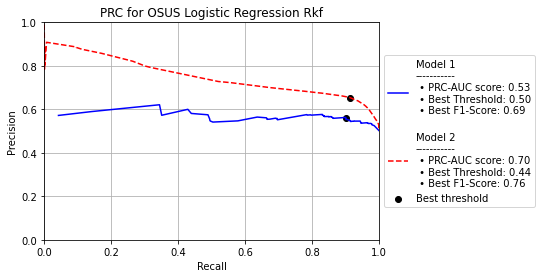

Best Threshold=0.397204, F1-Score=0.764 for model 1
Best Threshold=0.397206, F1-Score=0.764 for model 2


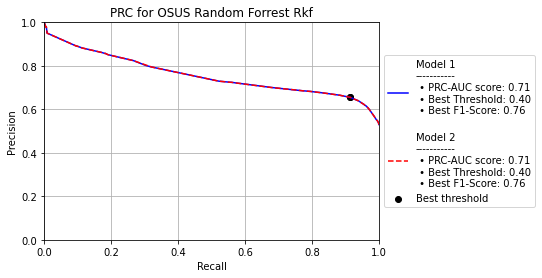

Best Threshold=0.397515, F1-Score=0.764 for model 1
Best Threshold=0.397925, F1-Score=0.764 for model 2


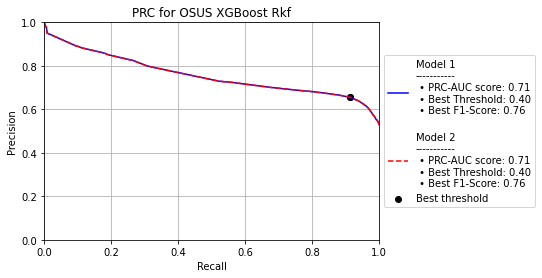

Best Threshold=0.503552, F1-Score=0.838 for model 1
Best Threshold=0.444506, F1-Score=0.692 for model 2


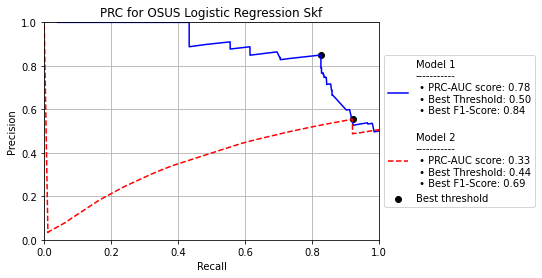

Best Threshold=0.452877, F1-Score=0.685 for model 1
Best Threshold=0.443420, F1-Score=0.711 for model 2


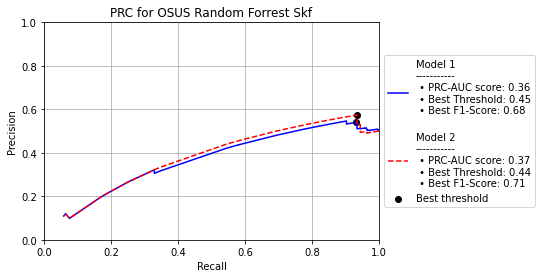

Best Threshold=0.437873, F1-Score=0.695 for model 1
Best Threshold=0.106968, F1-Score=0.718 for model 2


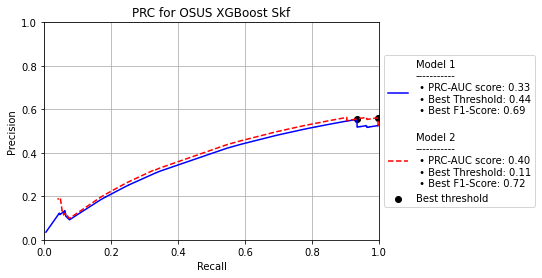

Best Threshold=0.000000, F1-Score=1.000 for model 1
Best Threshold=0.000002, F1-Score=1.000 for model 2


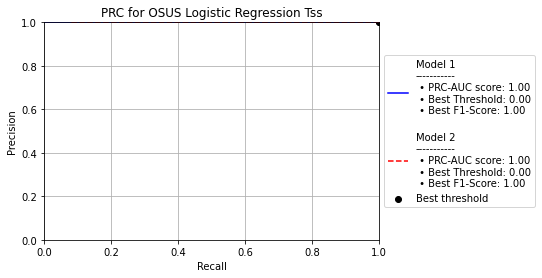

Best Threshold=0.509527, F1-Score=0.681 for model 1
Best Threshold=0.391310, F1-Score=0.711 for model 2


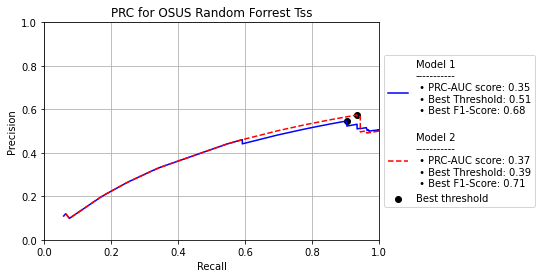

Best Threshold=0.000002, F1-Score=1.000 for model 1
Best Threshold=0.000002, F1-Score=1.000 for model 2


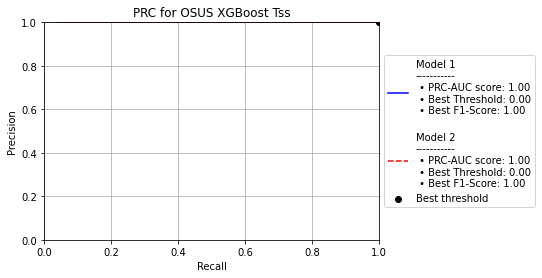

In [80]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "OSUS Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "OSUS Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "OSUS XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "OSUS Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "OSUS Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "OSUS XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "OSUS Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "OSUS Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "OSUS XGBoost Tss")

In [81]:
results_df = pd.DataFrame(results_data, columns = ['Test', 'Model1 score', 'Model2 score', 'Model1 accuracy', 'Model2 accuracy', 'Model1 avg. PR score', 'Model2 avg. PR score', 'Model1 PRC-AUC Score', 'Model2 PRC-AUC Score'])
model1_results_df = results_df[['Test', 'Model1 score', 'Model1 accuracy', 'Model1 avg. PR score', 'Model1 PRC-AUC Score']]
model2_results_df = results_df[['Test', 'Model2 score', 'Model2 accuracy', 'Model2 avg. PR score', 'Model2 PRC-AUC Score']]

In [82]:
results_df

,Test,Model1 score,Model2 score,Model1 accuracy,Model2 accuracy,Model1 avg. PR score,Model2 avg. PR score,Model1 PRC-AUC Score,Model2 PRC-AUC Score
0,Original_Logistic_Regression,0.786271,0.806079,0.786271,0.806079,0.197094,0.432997,0.190127,0.445765
1,Original_Random_Forrest,0.806480,0.806480,0.806480,0.806480,0.440673,0.440610,0.464858,0.464835
2,Original_XGB_Classifier,0.806480,0.806480,0.806480,0.806480,0.440574,0.440640,0.464708,0.464817
3,Original_Logistic_Regression_Best_Threshold,0.786271,0.806079,0.281746,0.638945,0.197094,0.432997,0.186853,0.390906
4,Original_Random_Forrest_Best_Threshold,0.806480,0.806480,0.657159,0.657159,0.440673,0.440610,0.397500,0.397493
...,...,...,...,...,...,...,...,...,...
67,OSUS_Combination_XGB_Classifier_skf,0.575925,0.600353,0.575925,0.600353,0.541451,0.556454,0.331839,0.398690
68,OSUS_Combination_Logistic_Regression_tss,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
69,OSUS_Combination_Logistic_Regression_tss_Best_...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
70,OSUS_Combination_Random_Forrest_tss,0.576663,0.604749,0.576663,0.604749,0.541892,0.559250,0.348389,0.372170


In [83]:
model1_results_df

,Test,Model1 score,Model1 accuracy,Model1 avg. PR score,Model1 PRC-AUC Score
0,Original_Logistic_Regression,0.786271,0.786271,0.197094,0.190127
1,Original_Random_Forrest,0.806480,0.806480,0.440673,0.464858
2,Original_XGB_Classifier,0.806480,0.806480,0.440574,0.464708
3,Original_Logistic_Regression_Best_Threshold,0.786271,0.281746,0.197094,0.186853
4,Original_Random_Forrest_Best_Threshold,0.806480,0.657159,0.440673,0.397500
...,...,...,...,...,...
67,OSUS_Combination_XGB_Classifier_skf,0.575925,0.575925,0.541451,0.331839
68,OSUS_Combination_Logistic_Regression_tss,0.000000,0.000000,1.000000,1.000000
69,OSUS_Combination_Logistic_Regression_tss_Best_...,0.000000,0.000000,1.000000,1.000000
70,OSUS_Combination_Random_Forrest_tss,0.576663,0.576663,0.541892,0.348389


In [84]:
model2_results_df

,Test,Model2 score,Model2 accuracy,Model2 avg. PR score,Model2 PRC-AUC Score
0,Original_Logistic_Regression,0.806079,0.806079,0.432997,0.445765
1,Original_Random_Forrest,0.806480,0.806480,0.440610,0.464835
2,Original_XGB_Classifier,0.806480,0.806480,0.440640,0.464817
3,Original_Logistic_Regression_Best_Threshold,0.806079,0.638945,0.432997,0.390906
4,Original_Random_Forrest_Best_Threshold,0.806480,0.657159,0.440610,0.397493
...,...,...,...,...,...
67,OSUS_Combination_XGB_Classifier_skf,0.600353,0.600353,0.556454,0.398690
68,OSUS_Combination_Logistic_Regression_tss,0.000000,0.000000,1.000000,1.000000
69,OSUS_Combination_Logistic_Regression_tss_Best_...,0.000000,0.000000,1.000000,1.000000
70,OSUS_Combination_Random_Forrest_tss,0.604749,0.604749,0.559250,0.372170


In [85]:
model1_results_df[~model1_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model1 PRC-AUC Score', 'Model1 score'], ascending=False)

,Test,Model1 score,Model1 accuracy,Model1 avg. PR score,Model1 PRC-AUC Score
46,Oversampled_Logistic_Regression_skf,0.779585,0.779585,0.708839,0.779447
64,OSUS_Combination_Logistic_Regression_skf,0.777423,0.777423,0.706955,0.775122
25,Undersampled_Logistic_Regression_rkf_Best_Thre...,0.452632,0.452632,0.545720,0.775000
37,Oversampled_Random_Forrest,0.714206,0.714206,0.738851,0.753946
38,Oversampled_XGB_Classifier,0.714170,0.714170,0.738805,0.753893
56,OSUS_Combination_XGB_Classifier,0.713774,0.713774,0.738294,0.753245
55,OSUS_Combination_Random_Forrest,0.713798,0.713798,0.738286,0.752851
43,Oversampled_Logistic_Regression_rkf_Best_Thres...,0.594985,0.594985,0.555758,0.729925
61,OSUS_Combination_Logistic_Regression_rkf_Best_...,0.594866,0.594866,0.555069,0.729898
29,Undersampled_Logistic_Regression_skf_Best_Thre...,0.555263,0.555263,0.530802,0.726988


In [86]:
model2_results_df[~model2_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model2 PRC-AUC Score'], ascending=False)

,Test,Model2 score,Model2 accuracy,Model2 avg. PR score,Model2 PRC-AUC Score
25,Undersampled_Logistic_Regression_rkf_Best_Thre...,0.528947,0.528947,0.567361,0.769758
61,OSUS_Combination_Logistic_Regression_rkf_Best_...,0.716646,0.716646,0.644867,0.755679
38,Oversampled_XGB_Classifier,0.714176,0.714176,0.738784,0.753871
37,Oversampled_Random_Forrest,0.714182,0.714182,0.738781,0.753864
43,Oversampled_Logistic_Regression_rkf_Best_Thres...,0.715956,0.715956,0.645221,0.753837
56,OSUS_Combination_XGB_Classifier,0.713629,0.713629,0.738239,0.753209
55,OSUS_Combination_Random_Forrest,0.713653,0.713653,0.738223,0.752778
36,Oversampled_Logistic_Regression,0.713053,0.713053,0.736070,0.748400
54,OSUS_Combination_Logistic_Regression,0.712074,0.712074,0.734574,0.744348
29,Undersampled_Logistic_Regression_skf_Best_Thre...,0.550000,0.550000,0.527317,0.740818


In [89]:
figures = [lr_skf_os_fig, rf_os_fig, xgb_os_fig]

for i, figure in enumerate(figures):
    figure.savefig(f"../../img/Mahout/graphs/Precision vs. Recall Results/Figure_{i}", dpi=300, bbox_inches='tight')

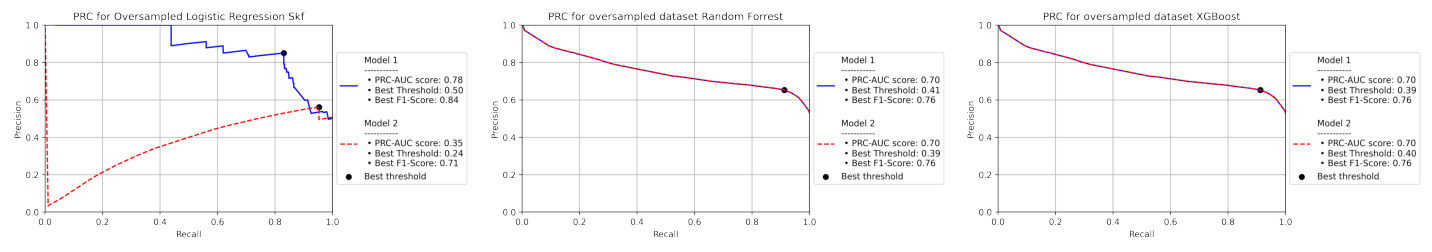

In [90]:
img_A = mpimg.imread('../../img/Mahout/graphs/Precision vs. Recall Results/Figure_0.png')
img_B = mpimg.imread('../../img/Mahout/graphs/Precision vs. Recall Results/Figure_1.png')
img_C = mpimg.imread('../../img/Mahout/graphs/Precision vs. Recall Results/Figure_2.png')
# display images
fig, ax = plt.subplots(1,3,figsize=(20,20))
ax[0].imshow(img_A);
ax[0].axis('off')
ax[1].imshow(img_B);
ax[1].axis('off')
ax[2].imshow(img_C);
ax[2].axis('off')
fig.tight_layout()
fig.savefig(f"../../img/Mahout/graphs/Precision vs. Recall Results/Figure_final.png", dpi=300, bbox_inches='tight')